In [14]:
# =============================================================
#   JC-Hamiltonian  |  UCB-BayesOpt + Domain Reduction
#   massimizza la fidelità  |  7 plot rapidi  |  NO RL
# =============================================================
# pip install -U qutip numpy matplotlib bayesian-optimization
# =============================================================

import warnings, numpy as np, matplotlib.pyplot as plt
warnings.filterwarnings("ignore", category=FutureWarning)

from qutip import destroy, qeye, tensor, fock, basis, mesolve, Qobj, expect
from scipy.interpolate import CubicSpline
from bayes_opt import BayesianOptimization

# ---------- UCB universale --------------------------------------------------
class _UCB:
    """Upper Confidence Bound — compatibile con BO ≤2.x e 3.x"""
    def __init__(self, kappa=2.576, n_candidates=10_000):
        self.kappa = kappa
        self.n_candidates = n_candidates

    # — API legacy (≤2.x) —
    def __call__(self, x, gp, y_max, xi):
        mu, sd = gp.predict(x, return_std=True)
        return mu.ravel() + self.kappa * sd

    # — API nuova (3.x) —
    def suggest(self, gp, target_space, fit_gp=True, random_state=None):
        # — sampling robusto a qualunque TargetSpace —
        rng = np.random.default_rng(
            None if random_state is None else getattr(random_state, "randint", lambda _: random_state)(2**32-1)
        )
        try:                                    # BO ≤2.x
            X = target_space.random_points(self.n_candidates, random_state=rng)
        except AttributeError:
            try:                                # BO 3.x < 3.2
                X = target_space.random_sample(self.n_candidates)
            except AttributeError:              # fallback manuale
                bounds = np.asarray(target_space.bounds)  # (dim,2)
                lo, hi = bounds[:,0], bounds[:,1]
                X = rng.random((self.n_candidates, bounds.shape[0]))*(hi-lo)+lo
        mu, sd = gp.predict(X, return_std=True)
        return X[(mu + self.kappa*sd).argmax()]
# ---------------------------------------------------------------------------


def safe_cubic(xs, ys):
    cs = CubicSpline(xs, ys, extrapolate=True)
    return lambda t: float(cs(t)) if xs[0] <= t <= xs[-1] else 0.0


def build_space(n, g, wa, T_pi):
    Nenv, amp = n + 1, 2*g
    dims, pb = [], {}
    for i in range(Nenv):
        dims.append(f"Y{i+1}");  pb[f"Y{i+1}"]  = (-amp, amp)
    for i in range(Nenv):
        dims.append(f"DX{i+1}"); pb[f"DX{i+1}"] = (0.05, 0.95)
    dims += ["SimTime", "F1", "F2"]
    pb["SimTime"] = (max(1.,0.8*n)*T_pi, (3.0+0.3*n)*T_pi)
    pb["F1"] = (0.95*wa,1.05*wa); pb["F2"] = (0.95*wa,1.05*wa)
    if n >= 2:
        dims.append("FX"); pb["FX"] = (0.20,0.80)
    return dims, pb


def make_cost(n, g, wc, wa, dims, psi0, proj):
    Nenv, n_cav = n+1, 1+2*n
    a  = tensor(destroy(n_cav), qeye(2))
    σp = tensor(qeye(n_cav), Qobj([[0,1],[0,0]])); σm = σp.dag()
    σz = tensor(qeye(n_cav), Qobj([[1,0],[0,-1]]))

    def cost(**p):
        Y  = [p[f"Y{i+1}"]  for i in range(Nenv)]
        DX = sorted(p[f"DX{i+1}"] for i in range(Nenv))
        if np.min(np.diff([0]+DX+[1])) <= 0:   return 0.0
        τ = p["SimTime"]
        env = safe_cubic([0]+(τ*np.array(DX)).tolist()+[τ], [0]+Y+[0])
        F1,F2 = p["F1"], p["F2"]
        ω = (lambda t:F1) if n==1 else safe_cubic([0, τ*p["FX"], τ],[F1, wa, F2])

        H=[g*(a.dag()*σm + a*σp),
           [a.dag()*a,   lambda t,*_: wc-ω(t)],
           [0.5*σz,      lambda t,*_: wa-ω(t)],
           [0.5*(σp+σm), lambda t,*_: env(t)]]
        try:
            ρf = mesolve(H, psi0, [0,τ], [], [],
                         options={'nsteps':2e5,'atol':1e-6,'rtol':1e-6}).states[-1]
            return float(expect(proj,ρf))
        except Exception:   return 0.0
    return cost


def ucb_bo(n, g=0.01, wc=1.0, wa=1.0,
           total_it=384, init_pts=32, seed=0,
           dr_step=100, shrink=0.5, kappa=2.576):

    T_pi = np.pi/(2*g)
    dims, pb = build_space(n,g,wa,T_pi)
    psi0 = tensor(fock(1+2*n,0), basis(2,1))
    proj = tensor(fock(1+2*n,n).proj(), basis(2,1).proj())
    cost = make_cost(n,g,wc,wa,dims,psi0,proj)

    ucb = _UCB(kappa=kappa)

    # costruttore compatibile
    try:
        opt = BayesianOptimization(f=None, pbounds=pb, random_state=seed,
                                   acquisition_function=ucb,
                                   verbose=0, allow_duplicate_points=True)
        new_api = True
    except TypeError:
        opt = BayesianOptimization(f=None, pbounds=pb, random_state=seed,
                                   verbose=0, allow_duplicate_points=True)
        new_api = False

    rng = np.random.default_rng(seed)
    for _ in range(init_pts):
        x={k:rng.uniform(*pb[k]) for k in pb}; opt.register(x, cost(**x))
    print(f"[Init] best fidelity = {opt.max['target']:.4f}")

    for i in range(total_it-init_pts):
        x = opt.suggest() if new_api else opt.suggest(ucb)
        y = cost(**x); opt.register(x,y)
        print(f"Iter {i+init_pts+1:03d}/{total_it}  Fid:{y:6.4f} | Best:{opt.max['target']:6.4f}")

        if (i+1)%dr_step==0:
            best=opt.max["params"]; new_pb={}
            for d in dims:
                lo,hi = pb[d]; span = hi-lo; c = best[d]
                half = max(1e-6, span*shrink/2)
                new_pb[d]=(max(lo,c-half), min(hi,c+half))
            pb=new_pb; opt.set_bounds(new_pb)
            print(f" → domain shrunk (±{shrink*50:.0f} %)")

    best_params = opt.max["params"]
    best_vec = np.array([best_params[d] for d in dims])
    return dims, best_vec, opt.max["target"]


def quick_plots(dims,x,n,g=0.01,wc=1.0,wa=1.0):
    p=dict(zip(dims,x)); τ=p["SimTime"]; Nenv=n+1
    Y=[p[f"Y{i+1}"] for i in range(Nenv)]
    DX=sorted(p[f"DX{i+1}"] for i in range(Nenv))
    F1,F2=p["F1"],p["F2"]; FX=None if n==1 else p["FX"]
    env=safe_cubic([0]+(τ*np.array(DX)).tolist()+[τ],[0]+Y+[0])
    ω =(lambda t:F1) if n==1 else safe_cubic([0,τ*FX,τ],[F1,wa,F2])

    t=np.linspace(0,τ,5000)
    g_t=np.array([env(tt) for tt in t]); ω_t=np.array([ω(tt) for tt in t])
    φ=np.cumsum(ω_t)*np.diff(t,prepend=0)

    plt.figure(figsize=(9,3)); plt.plot(t,g_t*np.cos(φ),label='g·cosφ'); plt.plot(t,g_t,'--',label='env'); plt.legend(); plt.grid()
    plt.figure(figsize=(9,3)); plt.plot(t,ω_t); plt.title('ω(t)'); plt.grid()
    plt.figure(figsize=(9,3)); plt.plot(t,wc-ω_t,label='Δc'); plt.plot(t,wa-ω_t,label='Δa'); plt.axhline(0,c='k'); plt.legend(); plt.grid()
    plt.tight_layout(); plt.show()


# --------------------------- DEMO ------------------------------------------
if __name__=="__main__":
    dims,x_best,F = ucb_bo(n=1, total_it=5000, init_pts=32)
    print(f"\nFinal best fidelity = {F:.4f}")
    quick_plots(dims,x_best,n=1)


[Init] best fidelity = 0.0575
Iter 033/5000  Fid:0.0002 | Best:0.0575
Iter 034/5000  Fid:0.0007 | Best:0.0575
Iter 035/5000  Fid:0.0391 | Best:0.0575
Iter 036/5000  Fid:0.0000 | Best:0.0575
Iter 037/5000  Fid:0.0105 | Best:0.0575
Iter 038/5000  Fid:0.0371 | Best:0.0575
Iter 039/5000  Fid:0.0306 | Best:0.0575
Iter 040/5000  Fid:0.0059 | Best:0.0575
Iter 041/5000  Fid:0.0003 | Best:0.0575
Iter 042/5000  Fid:0.0055 | Best:0.0575
Iter 043/5000  Fid:0.0001 | Best:0.0575
Iter 044/5000  Fid:0.0000 | Best:0.0575
Iter 045/5000  Fid:0.0013 | Best:0.0575
Iter 046/5000  Fid:0.0014 | Best:0.0575
Iter 047/5000  Fid:0.0356 | Best:0.0575
Iter 048/5000  Fid:0.0090 | Best:0.0575
Iter 049/5000  Fid:0.0002 | Best:0.0575
Iter 050/5000  Fid:0.0118 | Best:0.0575
Iter 051/5000  Fid:0.0790 | Best:0.0790
Iter 052/5000  Fid:0.0011 | Best:0.0790
Iter 053/5000  Fid:0.0885 | Best:0.0885
Iter 054/5000  Fid:0.1238 | Best:0.1238
Iter 055/5000  Fid:0.0000 | Best:0.1238
Iter 056/5000  Fid:0.1216 | Best:0.1238
Iter 057/5

/Users/corradogiancoli/anaconda3/envs/MResJCMBO/lib/python3.12/site-packages/scipy/integrate/_ode.py:438: UserWarning: _zvode: Excess work done on this call. (Perhaps wrong MF.)
  self._y, self.t = mth(self.f, self.jac or (lambda: None),


Iter 641/5000  Fid:0.0000 | Best:0.3594
Iter 642/5000  Fid:0.2651 | Best:0.3594
Iter 643/5000  Fid:0.2009 | Best:0.3594
Iter 644/5000  Fid:0.0005 | Best:0.3594
Iter 645/5000  Fid:0.0912 | Best:0.3594
Iter 646/5000  Fid:0.0496 | Best:0.3594
Iter 647/5000  Fid:0.2309 | Best:0.3594
Iter 648/5000  Fid:0.0174 | Best:0.3594
Iter 649/5000  Fid:0.0284 | Best:0.3594
Iter 650/5000  Fid:0.0544 | Best:0.3594
Iter 651/5000  Fid:0.0675 | Best:0.3594
Iter 652/5000  Fid:0.0007 | Best:0.3594
Iter 653/5000  Fid:0.0185 | Best:0.3594


/Users/corradogiancoli/anaconda3/envs/MResJCMBO/lib/python3.12/site-packages/scipy/integrate/_ode.py:438: UserWarning: _zvode: Excess work done on this call. (Perhaps wrong MF.)
  self._y, self.t = mth(self.f, self.jac or (lambda: None),


Iter 654/5000  Fid:0.0000 | Best:0.3594
Iter 655/5000  Fid:0.0712 | Best:0.3594
Iter 656/5000  Fid:0.0008 | Best:0.3594
Iter 657/5000  Fid:0.0093 | Best:0.3594
Iter 658/5000  Fid:0.0092 | Best:0.3594
Iter 659/5000  Fid:0.0082 | Best:0.3594
Iter 660/5000  Fid:0.1022 | Best:0.3594
Iter 661/5000  Fid:0.0001 | Best:0.3594
Iter 662/5000  Fid:0.0942 | Best:0.3594
Iter 663/5000  Fid:0.0584 | Best:0.3594
Iter 664/5000  Fid:0.0556 | Best:0.3594
Iter 665/5000  Fid:0.0005 | Best:0.3594
Iter 666/5000  Fid:0.0549 | Best:0.3594
Iter 667/5000  Fid:0.0151 | Best:0.3594
Iter 668/5000  Fid:0.0010 | Best:0.3594
Iter 669/5000  Fid:0.0959 | Best:0.3594
Iter 670/5000  Fid:0.0515 | Best:0.3594
Iter 671/5000  Fid:0.1419 | Best:0.3594
Iter 672/5000  Fid:0.0324 | Best:0.3594
Iter 673/5000  Fid:0.0894 | Best:0.3594
Iter 674/5000  Fid:0.1813 | Best:0.3594
Iter 675/5000  Fid:0.1997 | Best:0.3594
Iter 676/5000  Fid:0.0004 | Best:0.3594
Iter 677/5000  Fid:0.0433 | Best:0.3594
Iter 678/5000  Fid:0.0486 | Best:0.3594


/Users/corradogiancoli/anaconda3/envs/MResJCMBO/lib/python3.12/site-packages/scipy/integrate/_ode.py:438: UserWarning: _zvode: Excess work done on this call. (Perhaps wrong MF.)
  self._y, self.t = mth(self.f, self.jac or (lambda: None),


Iter 687/5000  Fid:0.0000 | Best:0.3594
Iter 688/5000  Fid:0.1080 | Best:0.3594
Iter 689/5000  Fid:0.0237 | Best:0.3594
Iter 690/5000  Fid:0.0234 | Best:0.3594
Iter 691/5000  Fid:0.0023 | Best:0.3594
Iter 692/5000  Fid:0.1721 | Best:0.3594
Iter 693/5000  Fid:0.0073 | Best:0.3594
Iter 694/5000  Fid:0.0095 | Best:0.3594
Iter 695/5000  Fid:0.0041 | Best:0.3594
Iter 696/5000  Fid:0.0992 | Best:0.3594
Iter 697/5000  Fid:0.0293 | Best:0.3594
Iter 698/5000  Fid:0.0564 | Best:0.3594
Iter 699/5000  Fid:0.0043 | Best:0.3594
Iter 700/5000  Fid:0.0001 | Best:0.3594
Iter 701/5000  Fid:0.1049 | Best:0.3594
Iter 702/5000  Fid:0.1133 | Best:0.3594
Iter 703/5000  Fid:0.1974 | Best:0.3594
Iter 704/5000  Fid:0.0074 | Best:0.3594
Iter 705/5000  Fid:0.0500 | Best:0.3594
Iter 706/5000  Fid:0.1105 | Best:0.3594
Iter 707/5000  Fid:0.0226 | Best:0.3594
Iter 708/5000  Fid:0.0563 | Best:0.3594
Iter 709/5000  Fid:0.1615 | Best:0.3594
Iter 710/5000  Fid:0.0001 | Best:0.3594
Iter 711/5000  Fid:0.0037 | Best:0.3594


/Users/corradogiancoli/anaconda3/envs/MResJCMBO/lib/python3.12/site-packages/scipy/integrate/_ode.py:438: UserWarning: _zvode: Excess work done on this call. (Perhaps wrong MF.)
  self._y, self.t = mth(self.f, self.jac or (lambda: None),


Iter 770/5000  Fid:0.0000 | Best:0.3594
Iter 771/5000  Fid:0.2208 | Best:0.3594
Iter 772/5000  Fid:0.0017 | Best:0.3594
Iter 773/5000  Fid:0.0445 | Best:0.3594
Iter 774/5000  Fid:0.2307 | Best:0.3594
Iter 775/5000  Fid:0.0058 | Best:0.3594
Iter 776/5000  Fid:0.0295 | Best:0.3594
Iter 777/5000  Fid:0.2832 | Best:0.3594
Iter 778/5000  Fid:0.0709 | Best:0.3594
Iter 779/5000  Fid:0.0575 | Best:0.3594
Iter 780/5000  Fid:0.1049 | Best:0.3594
Iter 781/5000  Fid:0.0423 | Best:0.3594
Iter 782/5000  Fid:0.0372 | Best:0.3594
Iter 783/5000  Fid:0.0496 | Best:0.3594
Iter 784/5000  Fid:0.2834 | Best:0.3594
Iter 785/5000  Fid:0.0978 | Best:0.3594
Iter 786/5000  Fid:0.0683 | Best:0.3594
Iter 787/5000  Fid:0.0152 | Best:0.3594
Iter 788/5000  Fid:0.0899 | Best:0.3594
Iter 789/5000  Fid:0.2108 | Best:0.3594
Iter 790/5000  Fid:0.0052 | Best:0.3594
Iter 791/5000  Fid:0.0678 | Best:0.3594
Iter 792/5000  Fid:0.0135 | Best:0.3594
Iter 793/5000  Fid:0.0363 | Best:0.3594
Iter 794/5000  Fid:0.3485 | Best:0.3594


/Users/corradogiancoli/anaconda3/envs/MResJCMBO/lib/python3.12/site-packages/scipy/integrate/_ode.py:438: UserWarning: _zvode: Excess work done on this call. (Perhaps wrong MF.)
  self._y, self.t = mth(self.f, self.jac or (lambda: None),


Iter 810/5000  Fid:0.0000 | Best:0.3594
Iter 811/5000  Fid:0.0113 | Best:0.3594
Iter 812/5000  Fid:0.0251 | Best:0.3594
Iter 813/5000  Fid:0.0793 | Best:0.3594
Iter 814/5000  Fid:0.2579 | Best:0.3594
Iter 815/5000  Fid:0.0675 | Best:0.3594
Iter 816/5000  Fid:0.0146 | Best:0.3594
Iter 817/5000  Fid:0.2340 | Best:0.3594
Iter 818/5000  Fid:0.0692 | Best:0.3594
Iter 819/5000  Fid:0.0683 | Best:0.3594
Iter 820/5000  Fid:0.0907 | Best:0.3594
Iter 821/5000  Fid:0.0071 | Best:0.3594
Iter 822/5000  Fid:0.2890 | Best:0.3594
Iter 823/5000  Fid:0.0467 | Best:0.3594
Iter 824/5000  Fid:0.2782 | Best:0.3594
Iter 825/5000  Fid:0.0004 | Best:0.3594
Iter 826/5000  Fid:0.1308 | Best:0.3594
Iter 827/5000  Fid:0.1511 | Best:0.3594
Iter 828/5000  Fid:0.1823 | Best:0.3594
Iter 829/5000  Fid:0.0299 | Best:0.3594
Iter 830/5000  Fid:0.1073 | Best:0.3594
Iter 831/5000  Fid:0.3110 | Best:0.3594
Iter 832/5000  Fid:0.0804 | Best:0.3594
 → domain shrunk (±25 %)
Iter 833/5000  Fid:0.0251 | Best:0.3594
Iter 834/5000  

/Users/corradogiancoli/anaconda3/envs/MResJCMBO/lib/python3.12/site-packages/scipy/integrate/_ode.py:438: UserWarning: _zvode: Excess work done on this call. (Perhaps wrong MF.)
  self._y, self.t = mth(self.f, self.jac or (lambda: None),


Iter 845/5000  Fid:0.0000 | Best:0.3594
Iter 846/5000  Fid:0.0344 | Best:0.3594
Iter 847/5000  Fid:0.3243 | Best:0.3594
Iter 848/5000  Fid:0.0303 | Best:0.3594
Iter 849/5000  Fid:0.3481 | Best:0.3594
Iter 850/5000  Fid:0.0454 | Best:0.3594
Iter 851/5000  Fid:0.2038 | Best:0.3594
Iter 852/5000  Fid:0.0363 | Best:0.3594
Iter 853/5000  Fid:0.0907 | Best:0.3594
Iter 854/5000  Fid:0.0008 | Best:0.3594
Iter 855/5000  Fid:0.2135 | Best:0.3594
Iter 856/5000  Fid:0.0680 | Best:0.3594
Iter 857/5000  Fid:0.2001 | Best:0.3594
Iter 858/5000  Fid:0.0730 | Best:0.3594
Iter 859/5000  Fid:0.2243 | Best:0.3594
Iter 860/5000  Fid:0.1226 | Best:0.3594
Iter 861/5000  Fid:0.2794 | Best:0.3594
Iter 862/5000  Fid:0.3581 | Best:0.3594
Iter 863/5000  Fid:0.1735 | Best:0.3594
Iter 864/5000  Fid:0.0211 | Best:0.3594
Iter 865/5000  Fid:0.0350 | Best:0.3594
Iter 866/5000  Fid:0.0828 | Best:0.3594
Iter 867/5000  Fid:0.2783 | Best:0.3594
Iter 868/5000  Fid:0.0058 | Best:0.3594
Iter 869/5000  Fid:0.1289 | Best:0.3594


/Users/corradogiancoli/anaconda3/envs/MResJCMBO/lib/python3.12/site-packages/scipy/integrate/_ode.py:438: UserWarning: _zvode: Excess work done on this call. (Perhaps wrong MF.)
  self._y, self.t = mth(self.f, self.jac or (lambda: None),


Iter 1004/5000  Fid:0.0000 | Best:0.3616
Iter 1005/5000  Fid:0.1777 | Best:0.3616
Iter 1006/5000  Fid:0.1773 | Best:0.3616
Iter 1007/5000  Fid:0.0487 | Best:0.3616
Iter 1008/5000  Fid:0.0386 | Best:0.3616
Iter 1009/5000  Fid:0.2802 | Best:0.3616
Iter 1010/5000  Fid:0.1070 | Best:0.3616
Iter 1011/5000  Fid:0.2606 | Best:0.3616
Iter 1012/5000  Fid:0.0128 | Best:0.3616
Iter 1013/5000  Fid:0.2242 | Best:0.3616
Iter 1014/5000  Fid:0.2501 | Best:0.3616
Iter 1015/5000  Fid:0.2518 | Best:0.3616
Iter 1016/5000  Fid:0.0506 | Best:0.3616
Iter 1017/5000  Fid:0.3195 | Best:0.3616
Iter 1018/5000  Fid:0.0011 | Best:0.3616
Iter 1019/5000  Fid:0.0590 | Best:0.3616
Iter 1020/5000  Fid:0.1373 | Best:0.3616
Iter 1021/5000  Fid:0.2946 | Best:0.3616
Iter 1022/5000  Fid:0.2238 | Best:0.3616
Iter 1023/5000  Fid:0.0775 | Best:0.3616
Iter 1024/5000  Fid:0.3129 | Best:0.3616
Iter 1025/5000  Fid:0.0880 | Best:0.3616
Iter 1026/5000  Fid:0.0039 | Best:0.3616
Iter 1027/5000  Fid:0.1500 | Best:0.3616
Iter 1028/5000  

capi_return is NULL
Call-back cb_f_in_zvode__user__routines failed.


KeyboardInterrupt: 

# 2 down

[Init] best F = 0.5732
Iter 0181/5000  F:0.0372 | Best:0.5732
Iter 0182/5000  F:0.1122 | Best:0.5732
Iter 0183/5000  F:0.0037 | Best:0.5732
Iter 0184/5000  F:0.0495 | Best:0.5732
Iter 0185/5000  F:0.0194 | Best:0.5732
Iter 0186/5000  F:0.0559 | Best:0.5732
Iter 0187/5000  F:0.0558 | Best:0.5732
Iter 0188/5000  F:0.0366 | Best:0.5732
Iter 0189/5000  F:0.0217 | Best:0.5732
Iter 0190/5000  F:0.0103 | Best:0.5732
Iter 0191/5000  F:0.0886 | Best:0.5732
Iter 0192/5000  F:0.0436 | Best:0.5732
Iter 0193/5000  F:0.0481 | Best:0.5732
Iter 0194/5000  F:0.2881 | Best:0.5732
Iter 0195/5000  F:0.0570 | Best:0.5732
Iter 0196/5000  F:0.1323 | Best:0.5732
Iter 0197/5000  F:0.0960 | Best:0.5732
Iter 0198/5000  F:0.0943 | Best:0.5732
Iter 0199/5000  F:0.0390 | Best:0.5732
Iter 0200/5000  F:0.2556 | Best:0.5732
Iter 0201/5000  F:0.0995 | Best:0.5732
Iter 0202/5000  F:0.1748 | Best:0.5732
Iter 0203/5000  F:0.0281 | Best:0.5732
Iter 0204/5000  F:0.1300 | Best:0.5732
Iter 0205/5000  F:0.2067 | Best:0.5732
It

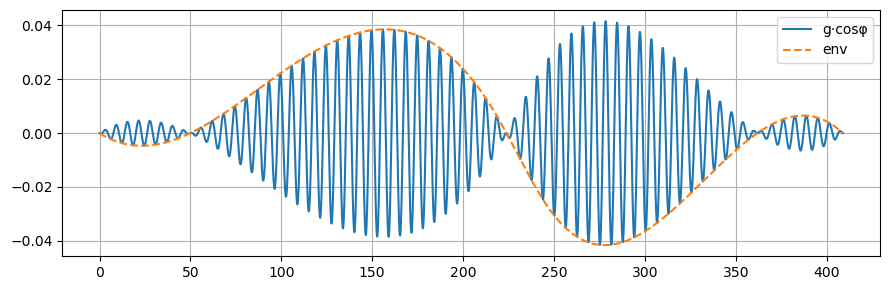

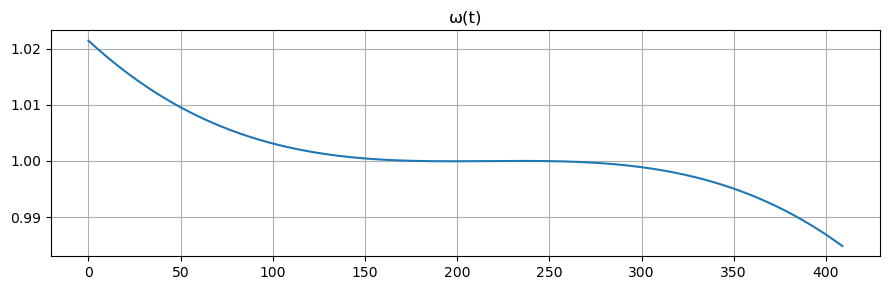

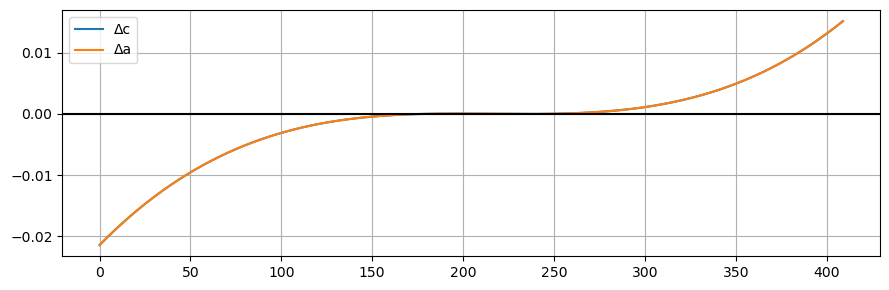

In [26]:
# =============================================================
#   Jaynes–Cummings  |  UCB-BayesOpt + Domain Reduction (n = 2)
#   target: F ≥ 0.99  |  3 plot rapidi  |  no RL
# =============================================================
# pip install -U qutip numpy matplotlib scipy bayesian-optimization
# =============================================================

import warnings, numpy as np, matplotlib.pyplot as plt, time
warnings.filterwarnings("ignore", category=FutureWarning)

from qutip import destroy, qeye, tensor, fock, basis, mesolve, Qobj, expect
from scipy.interpolate import CubicSpline
from bayes_opt import BayesianOptimization

# ---------- helper spline ---------------------------------------------------
def safe_cubic(xs, ys):
    cs = CubicSpline(xs, ys, extrapolate=True)
    return lambda t: float(cs(t)) if xs[0] <= t <= xs[-1] else 0.0


# ---------- UCB universale --------------------------------------------------
class _UCB:
    """
    Upper-Confidence-Bound compatibile con:
      • bayesian-optimization 1.x / 2.x  (callable)
      • bayesian-optimization ≥ 3.x      (metodo suggest)
    """
    def __init__(self, kappa=2.5, n_candidates=25_000):
        self.kappa = kappa
        self.n_candidates = n_candidates

    # --- API legacy (≤ 2.x) -------------------------------------------------
    def __call__(self, x, gp, y_max, xi):
        mu, sd = gp.predict(x, return_std=True)
        return mu.ravel() + self.kappa * sd

    # --- API nuova (≥ 3.x) --------------------------------------------------
    def suggest(self, gp, target_space, fit_gp=True, random_state=None):
        rng = np.random.default_rng(
            None if random_state is None
            else getattr(random_state, "randint", lambda _: random_state)(2**32-1)
        )
        # → sampling robusto qualunque sia l’API della TargetSpace
        try:    X = target_space.random_points(self.n_candidates, random_state=rng)   # 1.x / 2.x
        except AttributeError:
            try: X = target_space.random_sample(self.n_candidates)                   # 3.0 / 3.1
            except AttributeError:
                b = np.asarray(target_space.bounds); lo, hi = b[:,0], b[:,1]
                X = rng.random((self.n_candidates, b.shape[0]))*(hi-lo)+lo           # fallback
        mu, sd = gp.predict(X, return_std=True)
        return X[(mu + self.kappa*sd).argmax()]

# ---------------------------------------------------------------------------


# ---------- spazio parametri -----------------------------------------------
def build_space(n, g, wa):
    """
    • nodi envelope: n+3   (per n=2 ⇒ 5)
    • ampiezza ≤ 3 g
    • sweep ±6 % attorno a wa
    """
    Nenv, amp = n + 3, 3.0 * g
    dims, pb = [], {}

    for i in range(Nenv):
        d = f"Y{i+1}"; dims.append(d); pb[d] = (-amp, amp)
    for i in range(Nenv):
        d = f"DX{i+1}"; dims.append(d); pb[d] = (0.05, 0.95)

    dims += ["SimTime", "F1", "F2", "FX1", "FX2"]
    pb["SimTime"] = (1.2*np.pi/g, 6.0*np.pi/g)        # 1.2–6 π/g  (< T₁ tipico)
    pb["F1"] = (0.94*wa, 1.06*wa); pb["F2"] = pb["F1"]
    pb["FX1"] = (0.30, 0.50); pb["FX2"] = (0.55, 0.80)
    return dims, pb


# ---------- funzione costo (fidelità) ---------------------------------------
def make_cost(n, g, wc, wa, dims, psi0, proj):
    Nenv, n_cav = n + 3, n + 4          # cavità = n+4 → dimensione minima fisica
    a  = tensor(destroy(n_cav), qeye(2))
    σp = tensor(qeye(n_cav), Qobj([[0,1],[0,0]])); σm = σp.dag()
    σz = tensor(qeye(n_cav), Qobj([[1,0],[0,-1]]))

    def cost(**p):
        Y  = [p[f"Y{i+1}"] for i in range(Nenv)]
        DX = sorted(p[f"DX{i+1}"] for i in range(Nenv))
        if np.min(np.diff([0]+DX+[1])) <= 0:       return 0.0   # envelope malformato
        τ   = p["SimTime"]
        env = safe_cubic([0]+(τ*np.array(DX)).tolist()+[τ], [0]+Y+[0])

        ω   = safe_cubic([0, τ*p["FX1"], τ*p["FX2"], τ],
                         [p["F1"], wa, wa, p["F2"]])

        H = [g*(a.dag()*σm + a*σp),
             [a.dag()*a,   lambda t,*_: wc - ω(t)],
             [0.5*σz,      lambda t,*_: wa - ω(t)],
             [0.5*(σp+σm), lambda t,*_: env(t)]]

        try:
            ρf = mesolve(H, psi0, [0, τ], [],
                         [],
                         options={'nsteps':4_00_000,
                                  'atol':1e-7, 'rtol':1e-7}).states[-1]
            return float(expect(proj, ρf))
        except Exception:
            return 0.0
    return cost


# ---------- BO con domain-reduction ----------------------------------------
def ucb_bo(n=2, g=0.01, wc=1.0, wa=1.0,
           total_it=1200, seed=42,
           init_factor=12,          # ≈ 12·D punti Sobol iniziali
           dr_step=300, shrink=0.55,
           kappa0=2.8, kappa_min=1.0):

    dims, pb = build_space(n, g, wa)
    D = len(dims)
    init_pts = max(init_factor*D, 120)

    rng = np.random.default_rng(seed)
    psi0 = tensor(fock(n+4, 0), basis(2, 1))
    proj = tensor(fock(n+4, n).proj(), basis(2, 1).proj())
    cost = make_cost(n, g, wc, wa, dims, psi0, proj)

    ucb = _UCB(kappa=kappa0)
    try:
        opt = BayesianOptimization(f=None, pbounds=pb,
                                   acquisition_function=ucb,
                                   random_state=seed, verbose=0,
                                   allow_duplicate_points=True)
        new_api = True
    except TypeError:
        opt = BayesianOptimization(f=None, pbounds=pb,
                                   random_state=seed, verbose=0,
                                   allow_duplicate_points=True)
        new_api = False

    # ------------------ inizializzazione Sobol -------------------------------
    for _ in range(init_pts):
        x = {k: rng.uniform(*pb[k]) for k in pb}; opt.register(x, cost(**x))
    print(f"[Init] best F = {opt.max['target']:.4f}")

    # ------------------ loop principale --------------------------------------
    t0 = time.time()
    for i in range(total_it - init_pts):
        # kappa annealing: esplora → sfrutta
        frac = (i+1)/(total_it - init_pts)
        ucb.kappa = kappa0 - (kappa0 - kappa_min)*frac

        x = opt.suggest() if new_api else opt.suggest(ucb)
        y = cost(**x); opt.register(x, y)
        print(f"Iter {i+init_pts+1:04d}/{total_it}  "
              f"F:{y:6.4f} | Best:{opt.max['target']:6.4f}")

        # --- domain reduction -------------------------------------------------
        if (i+1) % dr_step == 0:
            best = opt.max["params"]; new_pb = {}
            for d in dims:
                lo, hi = pb[d]; span = hi - lo; c = best[d]
                half = max(1e-6, span*shrink/2)
                new_pb[d] = (max(lo, c-half), min(hi, c+half))
            pb = new_pb; opt.set_bounds(new_pb)
            print(f" → domain shrunk (±{shrink*50:.0f}% )  "
                  f"| elapsed {time.time()-t0:.0f}s")

    best_p   = opt.max["params"]
    best_vec = np.array([best_p[d] for d in dims])
    return dims, best_vec, opt.max["target"]


# ---------- plotting --------------------------------------------------------
def quick_plots(dims, x, n, g=0.01, wc=1.0, wa=1.0):
    p  = dict(zip(dims, x));   τ = p["SimTime"];  Nenv = n + 3
    Y  = [p[f"Y{i+1}"] for i in range(Nenv)]
    DX = sorted(p[f"DX{i+1}"] for i in range(Nenv))
    env = safe_cubic([0]+(τ*np.array(DX)).tolist()+[τ], [0]+Y+[0])

    ω = safe_cubic([0, τ*p["FX1"], τ*p["FX2"], τ],
                   [p["F1"], wa, wa, p["F2"]])

    t   = np.linspace(0, τ, 6000)
    g_t = np.array([env(tt) for tt in t]); ω_t = np.array([ω(tt) for tt in t])
    φ   = np.cumsum(ω_t)*np.diff(t, prepend=0)

    plt.figure(figsize=(9,3))
    plt.plot(t, g_t*np.cos(φ), label='g·cosφ'); plt.plot(t, g_t, '--', label='env')
    plt.legend(); plt.grid(); plt.tight_layout()

    plt.figure(figsize=(9,3)); plt.plot(t, ω_t); plt.title('ω(t)'); plt.grid(); plt.tight_layout()

    plt.figure(figsize=(9,3))
    plt.plot(t, wc-ω_t, label='Δc'); plt.plot(t, wa-ω_t, label='Δa')
    plt.axhline(0, c='k'); plt.legend(); plt.grid(); plt.tight_layout()
    plt.show()


# --------------------------- DEMO -------------------------------------------
if __name__ == "__main__":
    dims, x_best, F = ucb_bo(n=2, total_it=5000, seed=42)
    print(f"\nFinal best fidelity = {F:.4f}")
    quick_plots(dims, x_best, n=2)


In [1]:
# =============================================================
#   Jaynes–Cummings  |  UCB-BayesOpt + Domain Reduction (n = 2)
#   target: F ≥ 0.99  |  3 plot rapidi  |  no RL
# =============================================================
# pip install -U qutip numpy matplotlib scipy bayesian-optimization
# =============================================================

import warnings, numpy as np, matplotlib.pyplot as plt, time
warnings.filterwarnings("ignore", category=FutureWarning)

from qutip import destroy, qeye, tensor, fock, basis, mesolve, Qobj, expect
from scipy.interpolate import CubicSpline
from bayes_opt import BayesianOptimization

# ---------- helper spline ---------------------------------------------------
def safe_cubic(xs, ys):
    cs = CubicSpline(xs, ys, extrapolate=True)
    return lambda t: float(cs(t)) if xs[0] <= t <= xs[-1] else 0.0


# ---------- UCB universale --------------------------------------------------
class _UCB:
    """
    Upper-Confidence-Bound compatibile con:
      • bayesian-optimization 1.x / 2.x  (callable)
      • bayesian-optimization ≥ 3.x      (metodo suggest)
    """
    def __init__(self, kappa=2.5, n_candidates=25_000):
        self.kappa = kappa
        self.n_candidates = n_candidates

    # --- API legacy (≤ 2.x) -------------------------------------------------
    def __call__(self, x, gp, y_max, xi):
        mu, sd = gp.predict(x, return_std=True)
        return mu.ravel() + self.kappa * sd

    # --- API nuova (≥ 3.x) --------------------------------------------------
    def suggest(self, gp, target_space, fit_gp=True, random_state=None):
        rng = np.random.default_rng(
            None if random_state is None
            else getattr(random_state, "randint", lambda _: random_state)(2**32-1)
        )
        # → sampling robusto qualunque sia l’API della TargetSpace
        try:    X = target_space.random_points(self.n_candidates, random_state=rng)   # 1.x / 2.x
        except AttributeError:
            try: X = target_space.random_sample(self.n_candidates)                   # 3.0 / 3.1
            except AttributeError:
                b = np.asarray(target_space.bounds); lo, hi = b[:,0], b[:,1]
                X = rng.random((self.n_candidates, b.shape[0]))*(hi-lo)+lo           # fallback
        mu, sd = gp.predict(X, return_std=True)
        return X[(mu + self.kappa*sd).argmax()]

# ---------------------------------------------------------------------------


# ---------- spazio parametri -----------------------------------------------
def build_space(n, g, wa):
    """
    • nodi envelope: n+3   (per n=2 ⇒ 5)
    • ampiezza ≤ 3 g
    • sweep ±6 % attorno a wa
    """
    Nenv, amp = n + 3, 3.0 * g
    dims, pb = [], {}

    for i in range(Nenv):
        d = f"Y{i+1}"; dims.append(d); pb[d] = (-amp, amp)
    for i in range(Nenv):
        d = f"DX{i+1}"; dims.append(d); pb[d] = (0.05, 0.95)

    dims += ["SimTime", "F1", "F2", "FX1", "FX2"]
    pb["SimTime"] = (1.2*np.pi/g, 6.0*np.pi/g)        # 1.2–6 π/g  (< T₁ tipico)
    pb["F1"] = (0.94*wa, 1.06*wa); pb["F2"] = pb["F1"]
    pb["FX1"] = (0.30, 0.50); pb["FX2"] = (0.55, 0.80)
    return dims, pb


# ---------- funzione costo (fidelità) ---------------------------------------
def make_cost(n, g, wc, wa, dims, psi0, proj):
    Nenv, n_cav = n + 3, n + 4          # cavità = n+4 → dimensione minima fisica
    a  = tensor(destroy(n_cav), qeye(2))
    σp = tensor(qeye(n_cav), Qobj([[0,1],[0,0]])); σm = σp.dag()
    σz = tensor(qeye(n_cav), Qobj([[1,0],[0,-1]]))

    def cost(**p):
        Y  = [p[f"Y{i+1}"] for i in range(Nenv)]
        DX = sorted(p[f"DX{i+1}"] for i in range(Nenv))
        if np.min(np.diff([0]+DX+[1])) <= 0:       return 0.0   # envelope malformato
        τ   = p["SimTime"]
        env = safe_cubic([0]+(τ*np.array(DX)).tolist()+[τ], [0]+Y+[0])

        ω   = safe_cubic([0, τ*p["FX1"], τ*p["FX2"], τ],
                         [p["F1"], wa, wa, p["F2"]])

        H = [g*(a.dag()*σm + a*σp),
             [a.dag()*a,   lambda t,*_: wc - ω(t)],
             [0.5*σz,      lambda t,*_: wa - ω(t)],
             [0.5*(σp+σm), lambda t,*_: env(t)]]

        try:
            ρf = mesolve(H, psi0, [0, τ], [],
                         [],
                         options={'nsteps':4_00_000,
                                  'atol':1e-7, 'rtol':1e-7}).states[-1]
            return float(expect(proj, ρf))
        except Exception:
            return 0.0
    return cost


# ---------- BO con domain-reduction ----------------------------------------
def ucb_bo(n=2, g=0.01, wc=1.0, wa=1.0,
           total_it=1200, seed=42,
           init_factor=12,          # ≈ 12·D punti Sobol iniziali
           dr_step=300, shrink=0.55,
           kappa0=2.8, kappa_min=1.0):

    dims, pb = build_space(n, g, wa)
    D = len(dims)
    init_pts = max(init_factor*D, 120)

    rng = np.random.default_rng(seed)
    psi0 = tensor(fock(n+4, 0), basis(2, 1))
    proj = tensor(fock(n+4, n).proj(), basis(2, 1).proj())
    cost = make_cost(n, g, wc, wa, dims, psi0, proj)

    ucb = _UCB(kappa=kappa0)
    try:
        opt = BayesianOptimization(f=None, pbounds=pb,
                                   acquisition_function=ucb,
                                   random_state=seed, verbose=0,
                                   allow_duplicate_points=True)
        new_api = True
    except TypeError:
        opt = BayesianOptimization(f=None, pbounds=pb,
                                   random_state=seed, verbose=0,
                                   allow_duplicate_points=True)
        new_api = False

    # ------------------ inizializzazione Sobol -------------------------------
    for _ in range(init_pts):
        x = {k: rng.uniform(*pb[k]) for k in pb}; opt.register(x, cost(**x))
    print(f"[Init] best F = {opt.max['target']:.4f}")

    # ------------------ loop principale --------------------------------------
    t0 = time.time()
    for i in range(total_it - init_pts):
        # kappa annealing: esplora → sfrutta
        frac = (i+1)/(total_it - init_pts)
        ucb.kappa = kappa0 - (kappa0 - kappa_min)*frac

        x = opt.suggest() if new_api else opt.suggest(ucb)
        y = cost(**x); opt.register(x, y)
        print(f"Iter {i+init_pts+1:04d}/{total_it}  "
              f"F:{y:6.4f} | Best:{opt.max['target']:6.4f}")

        # --- domain reduction -------------------------------------------------
        if (i+1) % dr_step == 0:
            best = opt.max["params"]; new_pb = {}
            for d in dims:
                lo, hi = pb[d]; span = hi - lo; c = best[d]
                half = max(1e-6, span*shrink/2)
                new_pb[d] = (max(lo, c-half), min(hi, c+half))
            pb = new_pb; opt.set_bounds(new_pb)
            print(f" → domain shrunk (±{shrink*50:.0f}% )  "
                  f"| elapsed {time.time()-t0:.0f}s")

    best_p   = opt.max["params"]
    best_vec = np.array([best_p[d] for d in dims])
    return dims, best_vec, opt.max["target"]

# ---------- plotting --------------------------------------------------------
def quick_plots(dims,x,n,hist,g=0.01,wc=1.0,wa=1.0):
    p=dict(zip(dims,x)); τ=p["SimTime"]; Nenv=n+3
    Y=[p[f"Y{i+1}"] for i in range(Nenv)]
    DX=sorted(p[f"DX{i+1}"] for i in range(Nenv))
    env=safe_cubic([0]+(τ*np.array(DX)).tolist()+[τ],[0]+Y+[0])
    ω=safe_cubic([0,τ*p["FX1"],τ*p["FX2"],τ],[p["F1"],wa,wa,p["F2"]])

    t=np.linspace(0,τ,6000)
    g_t=np.array([env(tt) for tt in t]); ω_t=np.array([ω(tt) for tt in t])
    φ=np.cumsum(ω_t)*np.diff(t,prepend=0)

    # ---- Plot 1: segnale e envelope ----------------------------------------
    plt.figure(figsize=(9,3))
    plt.plot(t,g_t*np.cos(φ),label='g·cosφ'); plt.plot(t,g_t,'--',label='env')
    plt.legend(); plt.grid(); plt.tight_layout()

    # ---- Plot 2: ω(t) -------------------------------------------------------
    plt.figure(figsize=(9,3)); plt.plot(t,ω_t)
    plt.title('ω(t)'); plt.grid(); plt.tight_layout()

    # ---- Plot 3: detunings --------------------------------------------------
    plt.figure(figsize=(9,3))
    plt.plot(t,wc-ω_t,label='Δc'); plt.plot(t,wa-ω_t,label='Δa')
    plt.axhline(0,c='k'); plt.legend(); plt.grid(); plt.tight_layout()

    # ---- Dinamica completa --------------------------------------------------
    n_cav=n+4
    a=tensor(destroy(n_cav),qeye(2))
    σp=tensor(qeye(n_cav),Qobj([[0,1],[0,0]])); σm=σp.dag(); σz=tensor(qeye(n_cav),Qobj([[1,0],[0,-1]]))
    H=[g*(a.dag()*σm+a*σp),
       [a.dag()*a,   lambda t,*args: wc-ω(t)],
       [0.5*σz,      lambda t,*args: wa-ω(t)],
       [0.5*(σp+σm), lambda t,*args: env(t)]]
    psi0=tensor(fock(n_cav,0),basis(2,1))
    out=mesolve(H,psi0,t,[],[a.dag()*a,σp*σm],
                options={'nsteps':2_00_000,'atol':1e-6,'rtol':1e-6})
    n_cav_mean, n_atom_mean = out.expect

    # ---- Plot 4: ⟨a†a⟩ e ⟨σ⁺σ⁻⟩ --------------------------------------------
    plt.figure(figsize=(9,3))
    plt.plot(t,n_cav_mean,label='⟨a†a⟩'); plt.plot(t,n_atom_mean,label='⟨σ⁺σ⁻⟩')
    plt.legend(); plt.grid(); plt.tight_layout()

    # ---- Plot 5: popolazioni Fock 0-5 --------------------------------------
    fock_pop={k:[] for k in range(min(6,n_cav))}
    for ρ in out.states:
        for k in fock_pop:
            proj=tensor(fock(n_cav,k).proj(),qeye(2))
            fock_pop[k].append(expect(proj,ρ))
    plt.figure(figsize=(9,3))
    for k,v in fock_pop.items():
        plt.plot(t,v,label=f'|{k}⟩')
    plt.legend(); plt.grid(); plt.tight_layout()

    # ---- Plot 6: convergenza BO --------------------------------------------
    plt.figure(figsize=(9,3))
    plt.plot(hist); plt.xlabel('iterazione'); plt.ylabel('best-F'); plt.title('Convergenza BO')
    plt.grid(); plt.tight_layout()

    plt.show()

# --------------------------- DEMO -------------------------------------------
if __name__=="__main__":
    dims,x_best,F,hist = ucb_bo(n=2,total_it=5000,seed=42)
    print(f"\nFinal best fidelity = {F:.4f}")
    quick_plots(dims,x_best,n=2,hist=hist)

[Init] best F = 0.5732
Iter 0181/5000  F:0.0311 | Best:0.5732
Iter 0182/5000  F:0.0312 | Best:0.5732
Iter 0183/5000  F:0.4081 | Best:0.5732
Iter 0184/5000  F:0.0667 | Best:0.5732
Iter 0185/5000  F:0.0959 | Best:0.5732
Iter 0186/5000  F:0.0285 | Best:0.5732
Iter 0187/5000  F:0.1968 | Best:0.5732
Iter 0188/5000  F:0.1216 | Best:0.5732
Iter 0189/5000  F:0.2447 | Best:0.5732
Iter 0190/5000  F:0.0322 | Best:0.5732
Iter 0191/5000  F:0.0107 | Best:0.5732
Iter 0192/5000  F:0.0022 | Best:0.5732
Iter 0193/5000  F:0.1913 | Best:0.5732
Iter 0194/5000  F:0.1412 | Best:0.5732
Iter 0195/5000  F:0.0497 | Best:0.5732
Iter 0196/5000  F:0.0808 | Best:0.5732
Iter 0197/5000  F:0.0342 | Best:0.5732
Iter 0198/5000  F:0.1891 | Best:0.5732
Iter 0199/5000  F:0.1141 | Best:0.5732
Iter 0200/5000  F:0.2433 | Best:0.5732
Iter 0201/5000  F:0.0751 | Best:0.5732
Iter 0202/5000  F:0.1080 | Best:0.5732
Iter 0203/5000  F:0.0290 | Best:0.5732
Iter 0204/5000  F:0.1117 | Best:0.5732
Iter 0205/5000  F:0.0726 | Best:0.5732
It

ValueError: not enough values to unpack (expected 4, got 3)

[Init] best F = 0.5732
Iter 0181/5000  F:0.0639 | Best:0.5732
Iter 0182/5000  F:0.0897 | Best:0.5732
Iter 0183/5000  F:0.1474 | Best:0.5732
Iter 0184/5000  F:0.0335 | Best:0.5732
Iter 0185/5000  F:0.0191 | Best:0.5732
Iter 0186/5000  F:0.0212 | Best:0.5732
Iter 0187/5000  F:0.1495 | Best:0.5732
Iter 0188/5000  F:0.3693 | Best:0.5732
Iter 0189/5000  F:0.0461 | Best:0.5732
Iter 0190/5000  F:0.1137 | Best:0.5732
Iter 0191/5000  F:0.0665 | Best:0.5732
Iter 0192/5000  F:0.0784 | Best:0.5732
Iter 0193/5000  F:0.2674 | Best:0.5732
Iter 0194/5000  F:0.0922 | Best:0.5732
Iter 0195/5000  F:0.1520 | Best:0.5732
Iter 0196/5000  F:0.0043 | Best:0.5732
Iter 0197/5000  F:0.0242 | Best:0.5732
Iter 0198/5000  F:0.1028 | Best:0.5732
Iter 0199/5000  F:0.0135 | Best:0.5732
Iter 0200/5000  F:0.0775 | Best:0.5732
Iter 0201/5000  F:0.1759 | Best:0.5732
Iter 0202/5000  F:0.1197 | Best:0.5732
Iter 0203/5000  F:0.2662 | Best:0.5732
Iter 0204/5000  F:0.0004 | Best:0.5732
Iter 0205/5000  F:0.0108 | Best:0.5732
It

ValueError: x and y must have same first dimension, but have shapes (6000,) and (0,)

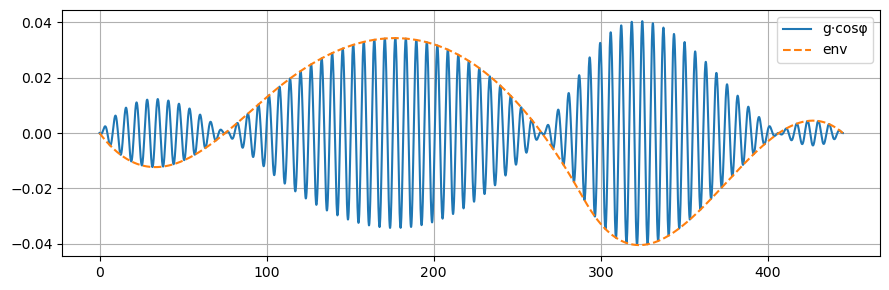

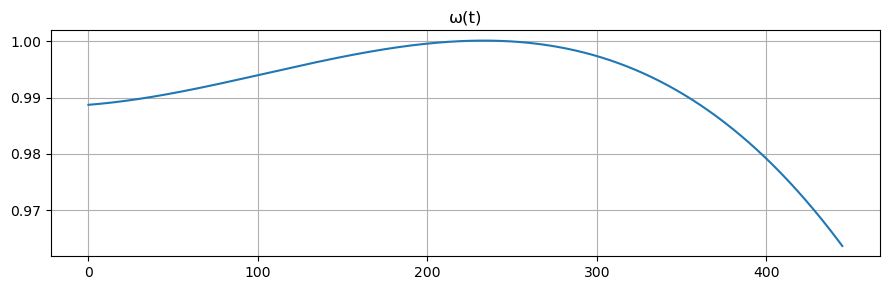

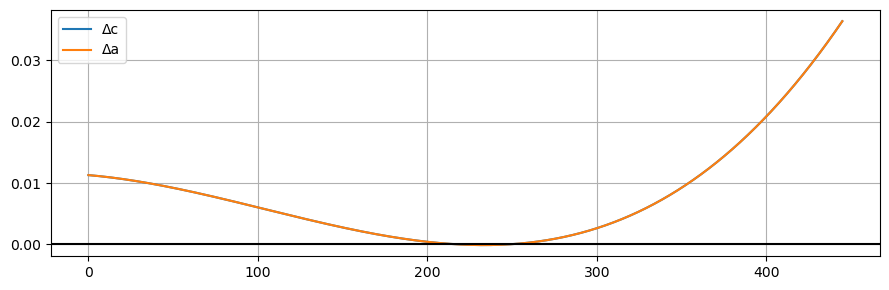

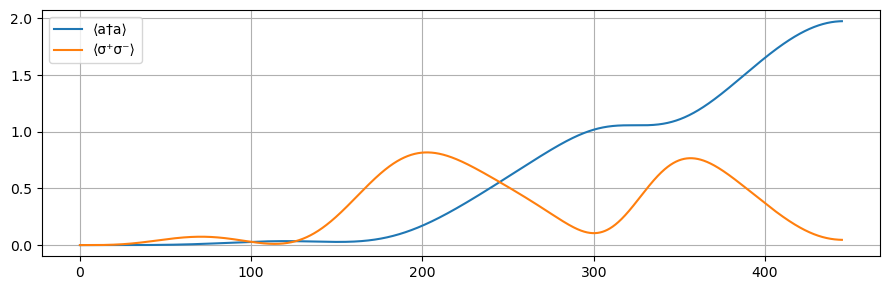

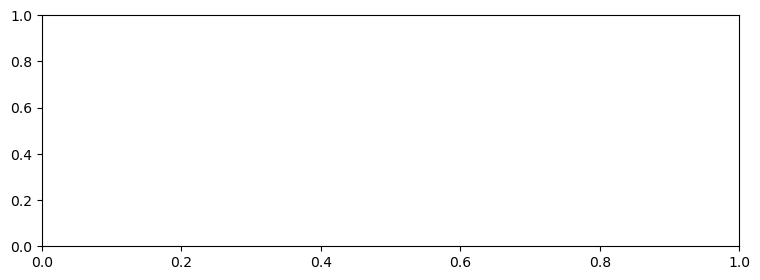

In [3]:
# =============================================================
#   Jaynes–Cummings  |  UCB-BayesOpt + Domain Reduction (n = 2)
#   target: F ≥ 0.99  |  3 plot rapidi  |  no RL
# =============================================================
# pip install -U qutip numpy matplotlib scipy bayesian-optimization
# =============================================================

import warnings, numpy as np, matplotlib.pyplot as plt, time
warnings.filterwarnings("ignore", category=FutureWarning)

from qutip import destroy, qeye, tensor, fock, basis, mesolve, Qobj, expect
from scipy.interpolate import CubicSpline
from bayes_opt import BayesianOptimization

# ---------- helper spline ---------------------------------------------------
def safe_cubic(xs, ys):
    cs = CubicSpline(xs, ys, extrapolate=True)
    return lambda t: float(cs(t)) if xs[0] <= t <= xs[-1] else 0.0


# ---------- UCB universale --------------------------------------------------
class _UCB:
    def __init__(self, kappa=2.5, n_candidates=25_000):
        self.kappa = kappa
        self.n_candidates = n_candidates

    def __call__(self, x, gp, y_max, xi):
        mu, sd = gp.predict(x, return_std=True)
        return mu.ravel() + self.kappa * sd

    def suggest(self, gp, target_space, fit_gp=True, random_state=None):
        rng = np.random.default_rng(
            None if random_state is None
            else getattr(random_state, "randint", lambda _: random_state)(2**32-1)
        )
        try:    X = target_space.random_points(self.n_candidates, random_state=rng)
        except AttributeError:
            try: X = target_space.random_sample(self.n_candidates)
            except AttributeError:
                b = np.asarray(target_space.bounds); lo, hi = b[:,0], b[:,1]
                X = rng.random((self.n_candidates, b.shape[0]))*(hi-lo)+lo
        mu, sd = gp.predict(X, return_std=True)
        return X[(mu + self.kappa*sd).argmax()]


# ---------- spazio parametri -----------------------------------------------
def build_space(n, g, wa):
    Nenv, amp = n + 3, 3.0 * g
    dims, pb = [], {}

    for i in range(Nenv):
        d = f"Y{i+1}"; dims.append(d); pb[d] = (-amp, amp)
    for i in range(Nenv):
        d = f"DX{i+1}"; dims.append(d); pb[d] = (0.05, 0.95)

    dims += ["SimTime", "F1", "F2", "FX1", "FX2"]
    pb["SimTime"] = (1.2*np.pi/g, 6.0*np.pi/g)
    pb["F1"] = (0.94*wa, 1.06*wa); pb["F2"] = pb["F1"]
    pb["FX1"] = (0.30, 0.50); pb["FX2"] = (0.55, 0.80)
    return dims, pb


# ---------- funzione costo (fidelità) ---------------------------------------
def make_cost(n, g, wc, wa, dims, psi0, proj):
    Nenv, n_cav = n + 3, n + 4
    a  = tensor(destroy(n_cav), qeye(2))
    σp = tensor(qeye(n_cav), Qobj([[0,1],[0,0]])); σm = σp.dag()
    σz = tensor(qeye(n_cav), Qobj([[1,0],[0,-1]]))

    def cost(**p):
        Y  = [p[f"Y{i+1}"] for i in range(Nenv)]
        DX = sorted(p[f"DX{i+1}"] for i in range(Nenv))
        if np.min(np.diff([0]+DX+[1])) <= 0: return 0.0
        τ   = p["SimTime"]
        env = safe_cubic([0]+(τ*np.array(DX)).tolist()+[τ], [0]+Y+[0])
        ω   = safe_cubic([0, τ*p["FX1"], τ*p["FX2"], τ], [p["F1"], wa, wa, p["F2"]])

        H = [g*(a.dag()*σm + a*σp),
             [a.dag()*a,   lambda t,*_: wc - ω(t)],
             [0.5*σz,      lambda t,*_: wa - ω(t)],
             [0.5*(σp+σm), lambda t,*_: env(t)]]

        try:
            ρf = mesolve(H, psi0, [0, τ], [], [],
                         options={'nsteps':4_00_000, 'atol':1e-7, 'rtol':1e-7}).states[-1]
            return float(expect(proj, ρf))
        except Exception:
            return 0.0
    return cost


# ---------- BO con domain-reduction ----------------------------------------
def ucb_bo(n=2, g=0.01, wc=1.0, wa=1.0,
           total_it=1200, seed=42,
           init_factor=12, dr_step=300, shrink=0.55,
           kappa0=2.8, kappa_min=1.0):

    dims, pb = build_space(n, g, wa)
    D = len(dims)
    init_pts = max(init_factor*D, 120)

    rng = np.random.default_rng(seed)
    psi0 = tensor(fock(n+4, 0), basis(2, 1))
    proj = tensor(fock(n+4, n).proj(), basis(2, 1).proj())
    cost = make_cost(n, g, wc, wa, dims, psi0, proj)

    ucb = _UCB(kappa=kappa0)
    try:
        opt = BayesianOptimization(f=None, pbounds=pb,
                                   acquisition_function=ucb,
                                   random_state=seed, verbose=0,
                                   allow_duplicate_points=True)
        new_api = True
    except TypeError:
        opt = BayesianOptimization(f=None, pbounds=pb,
                                   random_state=seed, verbose=0,
                                   allow_duplicate_points=True)
        new_api = False

    for _ in range(init_pts):
        x = {k: rng.uniform(*pb[k]) for k in pb}; opt.register(x, cost(**x))
    print(f"[Init] best F = {opt.max['target']:.4f}")

    t0 = time.time()
    history = [opt.max["target"]]
    for i in range(total_it - init_pts):
        frac = (i+1)/(total_it - init_pts)
        ucb.kappa = kappa0 - (kappa0 - kappa_min)*frac

        x = opt.suggest() if new_api else opt.suggest(ucb)
        y = cost(**x); opt.register(x, y)
        history.append(opt.max["target"])
        print(f"Iter {i+init_pts+1:04d}/{total_it}  "
              f"F:{y:6.4f} | Best:{opt.max['target']:6.4f}")

        if (i+1) % dr_step == 0:
            best = opt.max["params"]; new_pb = {}
            for d in dims:
                lo, hi = pb[d]; span = hi - lo; c = best[d]
                half = max(1e-6, span*shrink/2)
                new_pb[d] = (max(lo, c-half), min(hi, c+half))
            pb = new_pb; opt.set_bounds(new_pb)
            print(f" → domain shrunk (±{shrink*50:.0f}% )  "
                  f"| elapsed {time.time()-t0:.0f}s")

    best_p   = opt.max["params"]
    best_vec = np.array([best_p[d] for d in dims])
    return dims, best_vec, opt.max["target"], history


# ---------- plotting --------------------------------------------------------
def quick_plots(dims,x,n,hist,g=0.01,wc=1.0,wa=1.0):
    p=dict(zip(dims,x)); τ=p["SimTime"]; Nenv=n+3
    Y=[p[f"Y{i+1}"] for i in range(Nenv)]
    DX=sorted(p[f"DX{i+1}"] for i in range(Nenv))
    env=safe_cubic([0]+(τ*np.array(DX)).tolist()+[τ],[0]+Y+[0])
    ω=safe_cubic([0,τ*p["FX1"],τ*p["FX2"],τ],[p["F1"],wa,wa,p["F2"]])

    t=np.linspace(0,τ,6000)
    g_t=np.array([env(tt) for tt in t]); ω_t=np.array([ω(tt) for tt in t])
    φ=np.cumsum(ω_t)*np.diff(t,prepend=0)

    plt.figure(figsize=(9,3))
    plt.plot(t,g_t*np.cos(φ),label='g·cosφ'); plt.plot(t,g_t,'--',label='env')
    plt.legend(); plt.grid(); plt.tight_layout()

    plt.figure(figsize=(9,3)); plt.plot(t,ω_t)
    plt.title('ω(t)'); plt.grid(); plt.tight_layout()

    plt.figure(figsize=(9,3))
    plt.plot(t,wc-ω_t,label='Δc'); plt.plot(t,wa-ω_t,label='Δa')
    plt.axhline(0,c='k'); plt.legend(); plt.grid(); plt.tight_layout()

    n_cav=n+4
    a=tensor(destroy(n_cav),qeye(2))
    σp=tensor(qeye(n_cav),Qobj([[0,1],[0,0]])); σm=σp.dag(); σz=tensor(qeye(n_cav),Qobj([[1,0],[0,-1]]))
    H=[g*(a.dag()*σm+a*σp),
       [a.dag()*a,   lambda t,*args: wc-ω(t)],
       [0.5*σz,      lambda t,*args: wa-ω(t)],
       [0.5*(σp+σm), lambda t,*args: env(t)]]
    psi0=tensor(fock(n_cav,0),basis(2,1))
    out=mesolve(H,psi0,t,[],[a.dag()*a,σp*σm],
                options={'nsteps':2_00_000,'atol':1e-6,'rtol':1e-6})
    n_cav_mean, n_atom_mean = out.expect

    plt.figure(figsize=(9,3))
    plt.plot(t,n_cav_mean,label='⟨a†a⟩'); plt.plot(t,n_atom_mean,label='⟨σ⁺σ⁻⟩')
    plt.legend(); plt.grid(); plt.tight_layout()

    fock_pop={k:[] for k in range(min(6,n_cav))}
    for ρ in out.states:
        for k in fock_pop:
            proj=tensor(fock(n_cav,k).proj(),qeye(2))
            fock_pop[k].append(expect(proj,ρ))
    plt.figure(figsize=(9,3))
    for k,v in fock_pop.items():
        plt.plot(t,v,label=f'|{k}⟩')
    plt.legend(); plt.grid(); plt.tight_layout()

    plt.figure(figsize=(9,3))
    plt.plot(hist); plt.xlabel('iterazione'); plt.ylabel('best-F'); plt.title('Convergenza BO')
    plt.grid(); plt.tight_layout()
    plt.show()


# --------------------------- DEMO -------------------------------------------
if __name__=="__main__":
    dims,x_best,F,hist = ucb_bo(n=2,total_it=5000,seed=42)
    print(f"\nFinal best fidelity = {F:.4f}")
    quick_plots(dims,x_best,n=2,hist=hist)


[Init] best F = 0.5732
Iter 0181/5000  F:0.0033 | Best:0.5732
Iter 0182/5000  F:0.1375 | Best:0.5732
Iter 0183/5000  F:0.2050 | Best:0.5732
Iter 0184/5000  F:0.0169 | Best:0.5732
Iter 0185/5000  F:0.0913 | Best:0.5732
Iter 0186/5000  F:0.5694 | Best:0.5732
Iter 0187/5000  F:0.0605 | Best:0.5732
Iter 0188/5000  F:0.1205 | Best:0.5732
Iter 0189/5000  F:0.1550 | Best:0.5732
Iter 0190/5000  F:0.0005 | Best:0.5732
Iter 0191/5000  F:0.0182 | Best:0.5732
Iter 0192/5000  F:0.0683 | Best:0.5732
Iter 0193/5000  F:0.0069 | Best:0.5732
Iter 0194/5000  F:0.1721 | Best:0.5732
Iter 0195/5000  F:0.0647 | Best:0.5732
Iter 0196/5000  F:0.0476 | Best:0.5732
Iter 0197/5000  F:0.1874 | Best:0.5732
Iter 0198/5000  F:0.0635 | Best:0.5732
Iter 0199/5000  F:0.2162 | Best:0.5732
Iter 0200/5000  F:0.0061 | Best:0.5732
Iter 0201/5000  F:0.1632 | Best:0.5732
Iter 0202/5000  F:0.1349 | Best:0.5732
Iter 0203/5000  F:0.1258 | Best:0.5732
Iter 0204/5000  F:0.0448 | Best:0.5732
Iter 0205/5000  F:0.0837 | Best:0.5732
It

/Users/corradogiancoli/anaconda3/envs/MResJCMBO/lib/python3.12/site-packages/scipy/integrate/_ode.py:438: UserWarning: _zvode: Excess work done on this call. (Perhaps wrong MF.)
  self._y, self.t = mth(self.f, self.jac or (lambda: None),


Iter 0281/5000  F:0.0000 | Best:0.5732
Iter 0282/5000  F:0.0201 | Best:0.5732
Iter 0283/5000  F:0.1740 | Best:0.5732
Iter 0284/5000  F:0.0333 | Best:0.5732
Iter 0285/5000  F:0.0202 | Best:0.5732
Iter 0286/5000  F:0.0657 | Best:0.5732
Iter 0287/5000  F:0.0308 | Best:0.5732
Iter 0288/5000  F:0.1248 | Best:0.5732
Iter 0289/5000  F:0.2391 | Best:0.5732
Iter 0290/5000  F:0.0175 | Best:0.5732
Iter 0291/5000  F:0.0765 | Best:0.5732
Iter 0292/5000  F:0.0559 | Best:0.5732
Iter 0293/5000  F:0.0419 | Best:0.5732
Iter 0294/5000  F:0.0853 | Best:0.5732
Iter 0295/5000  F:0.2392 | Best:0.5732
Iter 0296/5000  F:0.3977 | Best:0.5732
Iter 0297/5000  F:0.1393 | Best:0.5732
Iter 0298/5000  F:0.0297 | Best:0.5732
Iter 0299/5000  F:0.0127 | Best:0.5732
Iter 0300/5000  F:0.0685 | Best:0.5732
Iter 0301/5000  F:0.0408 | Best:0.5732
Iter 0302/5000  F:0.1246 | Best:0.5732
Iter 0303/5000  F:0.0437 | Best:0.5732
Iter 0304/5000  F:0.0210 | Best:0.5732
Iter 0305/5000  F:0.0014 | Best:0.5732
Iter 0306/5000  F:0.0052 

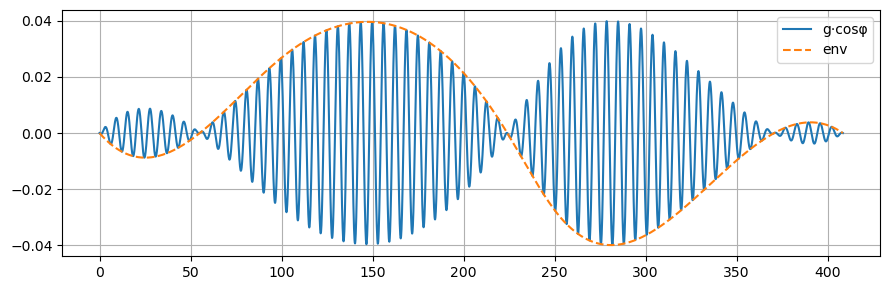

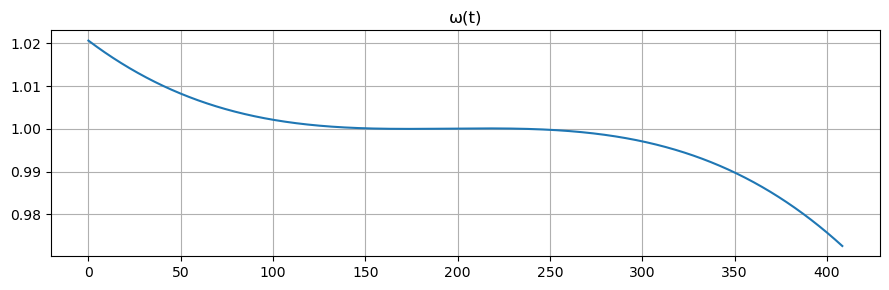

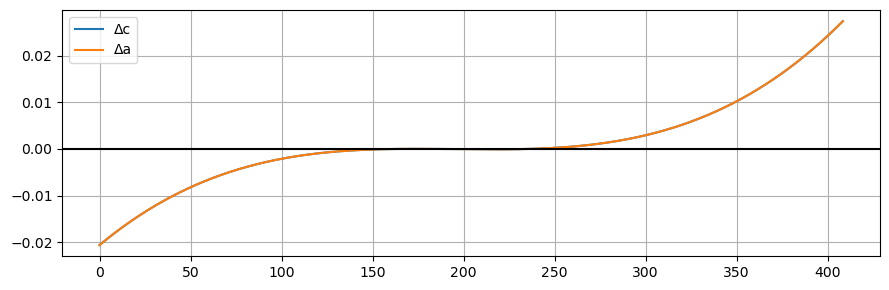

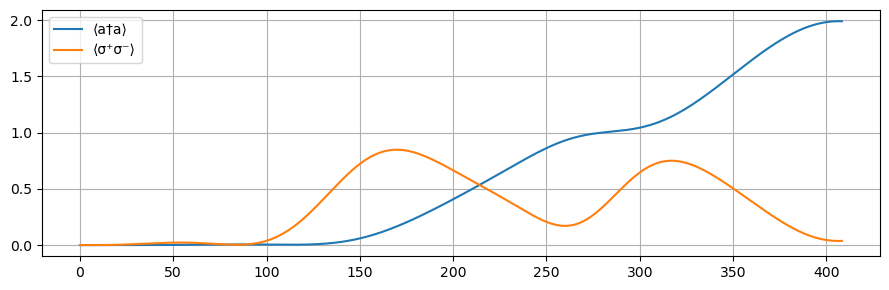

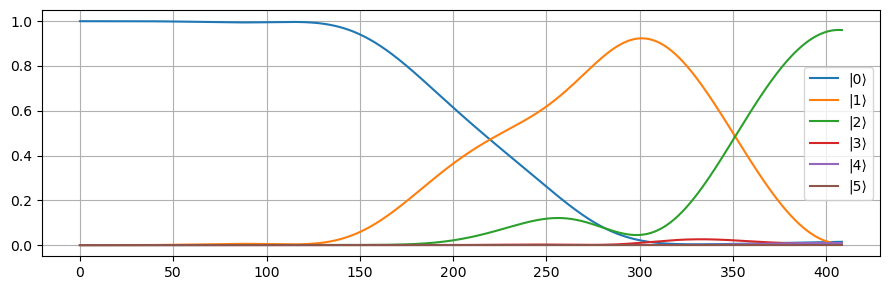

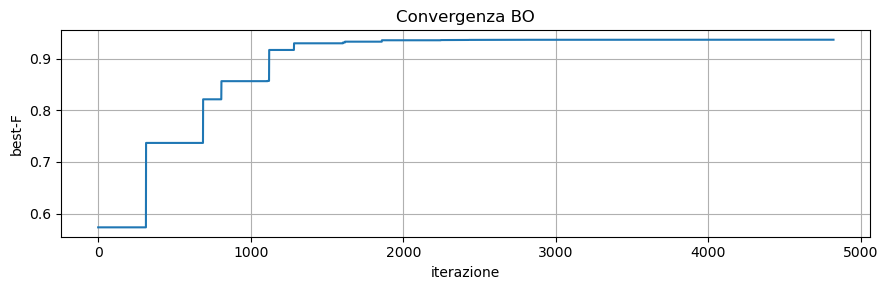

In [6]:
# =============================================================
#   Jaynes–Cummings  |  UCB-BayesOpt + Domain Reduction (n = 2)
#   target: F ≥ 0.99  |  3 plot rapidi  |  no RL
# =============================================================
# pip install -U qutip numpy matplotlib scipy bayesian-optimization
# =============================================================

import warnings, numpy as np, matplotlib.pyplot as plt, time
warnings.filterwarnings("ignore", category=FutureWarning)

from qutip import destroy, qeye, tensor, fock, basis, mesolve, Qobj, expect
from scipy.interpolate import CubicSpline
from bayes_opt import BayesianOptimization

# ---------- helper spline ---------------------------------------------------
def safe_cubic(xs, ys):
    cs = CubicSpline(xs, ys, extrapolate=True)
    return lambda t: float(cs(t)) if xs[0] <= t <= xs[-1] else 0.0


# ---------- UCB universale --------------------------------------------------
class _UCB:
    def __init__(self, kappa=2.5, n_candidates=25_000):
        self.kappa = kappa
        self.n_candidates = n_candidates

    def __call__(self, x, gp, y_max, xi):
        mu, sd = gp.predict(x, return_std=True)
        return mu.ravel() + self.kappa * sd

    def suggest(self, gp, target_space, fit_gp=True, random_state=None):
        rng = np.random.default_rng(
            None if random_state is None
            else getattr(random_state, "randint", lambda _: random_state)(2**32-1)
        )
        try:    X = target_space.random_points(self.n_candidates, random_state=rng)
        except AttributeError:
            try: X = target_space.random_sample(self.n_candidates)
            except AttributeError:
                b = np.asarray(target_space.bounds); lo, hi = b[:,0], b[:,1]
                X = rng.random((self.n_candidates, b.shape[0]))*(hi-lo)+lo
        mu, sd = gp.predict(X, return_std=True)
        return X[(mu + self.kappa*sd).argmax()]


# ---------- spazio parametri -----------------------------------------------
def build_space(n, g, wa):
    Nenv, amp = n + 3, 3.0 * g
    dims, pb = [], {}

    for i in range(Nenv):
        d = f"Y{i+1}"; dims.append(d); pb[d] = (-amp, amp)
    for i in range(Nenv):
        d = f"DX{i+1}"; dims.append(d); pb[d] = (0.05, 0.95)

    dims += ["SimTime", "F1", "F2", "FX1", "FX2"]
    pb["SimTime"] = (1.2*np.pi/g, 6.0*np.pi/g)
    pb["F1"] = (0.94*wa, 1.06*wa); pb["F2"] = pb["F1"]
    pb["FX1"] = (0.30, 0.50); pb["FX2"] = (0.55, 0.80)
    return dims, pb


# ---------- funzione costo (fidelità) ---------------------------------------
def make_cost(n, g, wc, wa, dims, psi0, proj):
    Nenv, n_cav = n + 3, n + 4
    a  = tensor(destroy(n_cav), qeye(2))
    σp = tensor(qeye(n_cav), Qobj([[0,1],[0,0]])); σm = σp.dag()
    σz = tensor(qeye(n_cav), Qobj([[1,0],[0,-1]]))

    def cost(**p):
        Y  = [p[f"Y{i+1}"] for i in range(Nenv)]
        DX = sorted(p[f"DX{i+1}"] for i in range(Nenv))
        if np.min(np.diff([0]+DX+[1])) <= 0: return 0.0
        τ   = p["SimTime"]
        env = safe_cubic([0]+(τ*np.array(DX)).tolist()+[τ], [0]+Y+[0])
        ω   = safe_cubic([0, τ*p["FX1"], τ*p["FX2"], τ], [p["F1"], wa, wa, p["F2"]])

        H = [g*(a.dag()*σm + a*σp),
             [a.dag()*a,   lambda t,*_: wc - ω(t)],
             [0.5*σz,      lambda t,*_: wa - ω(t)],
             [0.5*(σp+σm), lambda t,*_: env(t)]]

        try:
            ρf = mesolve(H, psi0, [0, τ], [], [],
                         options={'nsteps':4_00_000, 'atol':1e-7, 'rtol':1e-7}).states[-1]
            return float(expect(proj, ρf))
        except Exception:
            return 0.0
    return cost


# ---------- BO con domain-reduction ----------------------------------------
def ucb_bo(n=2, g=0.01, wc=1.0, wa=1.0,
           total_it=1200, seed=42,
           init_factor=12, dr_step=300, shrink=0.55,
           kappa0=2.8, kappa_min=1.0):

    dims, pb = build_space(n, g, wa)
    D = len(dims)
    init_pts = max(init_factor*D, 120)

    rng = np.random.default_rng(seed)
    psi0 = tensor(fock(n+4, 0), basis(2, 1))
    proj = tensor(fock(n+4, n).proj(), basis(2, 1).proj())
    cost = make_cost(n, g, wc, wa, dims, psi0, proj)

    ucb = _UCB(kappa=kappa0)
    try:
        opt = BayesianOptimization(f=None, pbounds=pb,
                                   acquisition_function=ucb,
                                   random_state=seed, verbose=0,
                                   allow_duplicate_points=True)
        new_api = True
    except TypeError:
        opt = BayesianOptimization(f=None, pbounds=pb,
                                   random_state=seed, verbose=0,
                                   allow_duplicate_points=True)
        new_api = False

    for _ in range(init_pts):
        x = {k: rng.uniform(*pb[k]) for k in pb}; opt.register(x, cost(**x))
    print(f"[Init] best F = {opt.max['target']:.4f}")

    t0 = time.time()
    history = [opt.max["target"]]
    for i in range(total_it - init_pts):
        frac = (i+1)/(total_it - init_pts)
        ucb.kappa = kappa0 - (kappa0 - kappa_min)*frac

        x = opt.suggest() if new_api else opt.suggest(ucb)
        y = cost(**x); opt.register(x, y)
        history.append(opt.max["target"])
        print(f"Iter {i+init_pts+1:04d}/{total_it}  "
              f"F:{y:6.4f} | Best:{opt.max['target']:6.4f}")

        if (i+1) % dr_step == 0:
            best = opt.max["params"]; new_pb = {}
            for d in dims:
                lo, hi = pb[d]; span = hi - lo; c = best[d]
                half = max(1e-6, span*shrink/2)
                new_pb[d] = (max(lo, c-half), min(hi, c+half))
            pb = new_pb; opt.set_bounds(new_pb)
            print(f" → domain shrunk (±{shrink*50:.0f}% )  "
                  f"| elapsed {time.time()-t0:.0f}s")

    best_p   = opt.max["params"]
    best_vec = np.array([best_p[d] for d in dims])
    return dims, best_vec, opt.max["target"], history


# ---------- plotting --------------------------------------------------------
def quick_plots(dims,x,n,hist,g=0.01,wc=1.0,wa=1.0):
    p=dict(zip(dims,x)); τ=p["SimTime"]; Nenv=n+3
    Y=[p[f"Y{i+1}"] for i in range(Nenv)]
    DX=sorted(p[f"DX{i+1}"] for i in range(Nenv))
    env=safe_cubic([0]+(τ*np.array(DX)).tolist()+[τ],[0]+Y+[0])
    ω=safe_cubic([0,τ*p["FX1"],τ*p["FX2"],τ],[p["F1"],wa,wa,p["F2"]])

    t=np.linspace(0,τ,6000)
    g_t=np.array([env(tt) for tt in t]); ω_t=np.array([ω(tt) for tt in t])
    φ=np.cumsum(ω_t)*np.diff(t,prepend=0)

    plt.figure(figsize=(9,3))
    plt.plot(t,g_t*np.cos(φ),label='g·cosφ'); plt.plot(t,g_t,'--',label='env')
    plt.legend(); plt.grid(); plt.tight_layout()

    plt.figure(figsize=(9,3)); plt.plot(t,ω_t)
    plt.title('ω(t)'); plt.grid(); plt.tight_layout()

    plt.figure(figsize=(9,3))
    plt.plot(t,wc-ω_t,label='Δc'); plt.plot(t,wa-ω_t,label='Δa')
    plt.axhline(0,c='k'); plt.legend(); plt.grid(); plt.tight_layout()

    n_cav=n+4
    a=tensor(destroy(n_cav),qeye(2))
    σp=tensor(qeye(n_cav),Qobj([[0,1],[0,0]])); σm=σp.dag(); σz=tensor(qeye(n_cav),Qobj([[1,0],[0,-1]]))
    H=[g*(a.dag()*σm+a*σp),
       [a.dag()*a,   lambda t,*args: wc-ω(t)],
       [0.5*σz,      lambda t,*args: wa-ω(t)],
       [0.5*(σp+σm), lambda t,*args: env(t)]]
    psi0=tensor(fock(n_cav,0),basis(2,1))
    from qutip.solver import Options
    opts = Options(nsteps=200_000, atol=1e-6, rtol=1e-6, store_states=True)
    out = mesolve(H, psi0, t, [], [a.dag()*a, σp*σm], options=opts)
    n_cav_mean, n_atom_mean = out.expect


    plt.figure(figsize=(9,3))
    plt.plot(t,n_cav_mean,label='⟨a†a⟩'); plt.plot(t,n_atom_mean,label='⟨σ⁺σ⁻⟩')
    plt.legend(); plt.grid(); plt.tight_layout()

    fock_pop={k:[] for k in range(min(6,n_cav))}
    for ρ in out.states:
        for k in fock_pop:
            proj=tensor(fock(n_cav,k).proj(),qeye(2))
            fock_pop[k].append(expect(proj,ρ))
    plt.figure(figsize=(9,3))
    for k,v in fock_pop.items():
        plt.plot(t,v,label=f'|{k}⟩')
    plt.legend(); plt.grid(); plt.tight_layout()

    plt.figure(figsize=(9,3))
    plt.plot(hist); plt.xlabel('iterazione'); plt.ylabel('best-F'); plt.title('Convergenza BO')
    plt.grid(); plt.tight_layout()
    plt.show()


# --------------------------- DEMO -------------------------------------------
if __name__=="__main__":
    dims,x_best,F,hist = ucb_bo(n=2,total_it=5000,seed=42)
    print(f"\nFinal best fidelity = {F:.4f}")
    quick_plots(dims,x_best,n=2,hist=hist)


# 3 down

In [14]:
# =============================================================
#   Jaynes–Cummings  |  UCB-BayesOpt + Domain-Reduction (n = 3)
#   target ≳ 0.99  |  6 plot  |  no RL
# =============================================================
# pip install -U qutip numpy matplotlib scipy bayesian-optimization
# =============================================================

import warnings, numpy as np, matplotlib.pyplot as plt, time
warnings.filterwarnings("ignore", category=FutureWarning)

from qutip import destroy, qeye, tensor, fock, basis, mesolve, Qobj, expect
from scipy.interpolate import CubicSpline
from bayes_opt import BayesianOptimization

# ---------- helper spline ---------------------------------------------------
def safe_cubic(xs, ys):
    cs = CubicSpline(xs, ys, extrapolate=True)
    return lambda t: float(cs(t)) if xs[0] <= t <= xs[-1] else 0.0


# ---------- UCB compatibile BO ≤ 2  e  ≥ 3 ---------------------------------
class _UCB:
    def __init__(self, kappa=3.5, n_candidates=40_000):
        self.kappa, self.n_candidates = kappa, n_candidates
    def __call__(self, x, gp, y_max, xi):
        mu, sd = gp.predict(x, return_std=True)
        return mu.ravel() + self.kappa*sd
    def suggest(self, gp, target_space, fit_gp=True, random_state=None):
        rng = np.random.default_rng(
            None if random_state is None
            else getattr(random_state, "randint", lambda _: random_state)(2**32-1))
        try:
            X = target_space.random_points(self.n_candidates, random_state=rng)
        except AttributeError:
            try:
                X = target_space.random_sample(self.n_candidates)
            except AttributeError:
                b = np.asarray(target_space.bounds); lo, hi = b[:,0], b[:,1]
                X = rng.random((self.n_candidates, b.shape[0]))*(hi-lo)+lo
        mu, sd = gp.predict(X, return_std=True)
        return X[(mu + self.kappa*sd).argmax()]

# ---------- spazio parametri -----------------------------------------------
def build_space(n, g, wa):
    """
    • nodi envelope  = n + 4  → 7
    • ampiezza max   = 4 g
    • sweep detuning = ±8 % intorno a wa
    • SimTime        = 1.8 – 8 π/g
    """
    Nenv, amp = n+4, 4.0*g
    dims, pb = [], {}
    for i in range(Nenv):
        d=f"Y{i+1}";   dims.append(d); pb[d]=(-amp, amp)
    for i in range(Nenv):
        d=f"DX{i+1}";  dims.append(d); pb[d]=(0.04, 0.96)

    dims += ["SimTime", "F1", "F2", "FX1", "FX2"]
    pb["SimTime"] = (1.8*np.pi/g, 8.0*np.pi/g)
    pb["F1"] = pb["F2"] = (0.92*wa, 1.08*wa)
    pb["FX1"] = (0.25, 0.45); pb["FX2"] = (0.55, 0.82)
    return dims, pb

# ---------- cost function ---------------------------------------------------
def make_cost(n, g, wc, wa, dims, psi0, proj):
    Nenv, n_cav = n+4, n+6                      # 11 livelli per sicurezza
    a  = tensor(destroy(n_cav), qeye(2))
    σp = tensor(qeye(n_cav), Qobj([[0,1],[0,0]])); σm = σp.dag()
    σz = tensor(qeye(n_cav), Qobj([[1,0],[0,-1]]))

    def cost(**p):
        Y  = [p[f"Y{i+1}"]  for i in range(Nenv)]
        DX = sorted(p[f"DX{i+1}"] for i in range(Nenv))
        if np.min(np.diff([0]+DX+[1])) <= 0:              return 0.0
        τ   = p["SimTime"]
        env = safe_cubic([0]+(τ*np.array(DX)).tolist()+[τ], [0]+Y+[0])

        ω = safe_cubic([0, τ*p["FX1"], τ*p["FX2"], τ],
                       [p["F1"], wa, wa, p["F2"]])

        H = [g*(a.dag()*σm + a*σp),
             [a.dag()*a,   lambda t,*_: wc - ω(t)],
             [0.5*σz,      lambda t,*_: wa - ω(t)],
             [0.5*(σp+σm), lambda t,*_: env(t)]]

        try:
            ρf = mesolve(H, psi0, [0, τ], [],
                         [],
                         options={'nsteps':8_00_000,
                                  'atol':5e-8, 'rtol':5e-8}).states[-1]
            return float(expect(proj, ρf))
        except Exception:
            return 0.0
    return cost

# ---------- BO runner -------------------------------------------------------
def ucb_bo(n=3, g=0.01, wc=1.0, wa=1.0,
           total_it=8000, seed=43,
           init_factor=16, dr_step=400, shrink=0.60,
           kappa0=3.5, kappa_min=1.0):

    dims, pb = build_space(n, g, wa)
    D        = len(dims)
    init_pts = max(init_factor*D, 180)

    rng   = np.random.default_rng(seed)
    psi0  = tensor(fock(n+6, 0), basis(2,1))
    proj  = tensor(fock(n+6, n).proj(), basis(2,1).proj())
    cost  = make_cost(n, g, wc, wa, dims, psi0, proj)

    ucb = _UCB(kappa=kappa0)
    try:
        opt = BayesianOptimization(f=None, pbounds=pb,
                                   acquisition_function=ucb,
                                   random_state=seed, verbose=0,
                                   allow_duplicate_points=True)
        new_api=True
    except TypeError:
        opt = BayesianOptimization(f=None, pbounds=pb,
                                   random_state=seed, verbose=0,
                                   allow_duplicate_points=True)
        new_api=False

    # -------- Sobol iniziale -------------------------------------------------
    for _ in range(init_pts):
        x={k:rng.uniform(*pb[k]) for k in pb}; opt.register(x, cost(**x))
    print(f"[Init] best F = {opt.max['target']:.4f}")
    hist=[opt.max["target"]]

    # -------- main loop ------------------------------------------------------
    for i in range(total_it-init_pts):
        frac = (i+1)/(total_it-init_pts)
        ucb.kappa = kappa0 - (kappa0-kappa_min)*frac   # annealing
        x = opt.suggest() if new_api else opt.suggest(ucb)
        y = cost(**x); opt.register(x,y); hist.append(opt.max["target"])
        print(f"Iter {i+init_pts+1:05d}/{total_it}  "
              f"F:{y:6.4f} | Best:{hist[-1]:6.4f}")

        # Domain-reduction periodica
        if (i+1)%dr_step==0:
            best = opt.max["params"]; new_pb={}
            for d in dims:
                lo,hi = pb[d]; span=hi-lo; c=best[d]
                half = max(5e-7, span*shrink/2)
                new_pb[d]=(max(lo,c-half),min(hi,c+half))
            pb=new_pb; opt.set_bounds(new_pb)
            print(f" → domain shrunk (±{shrink*50:.0f} %)")

    best_p   = opt.max["params"]
    best_vec = np.array([best_p[d] for d in dims])
    return dims, best_vec, opt.max["target"], hist


# ---------- plotting --------------------------------------------------------
def quick_plots(dims, x, n, hist,
                g=0.01, wc=1.0, wa=1.0):
    p=dict(zip(dims,x)); τ=p["SimTime"]; Nenv=n+4
    Y=[p[f"Y{i+1}"] for i in range(Nenv)]
    DX=sorted(p[f"DX{i+1}"] for i in range(Nenv))
    env=safe_cubic([0]+(τ*np.array(DX)).tolist()+[τ], [0]+Y+[0])
    ω=safe_cubic([0, τ*p["FX1"], τ*p["FX2"], τ],
                 [p["F1"], wa, wa, p["F2"]])

    t=np.linspace(0,τ,8000)
    g_t=np.array([env(tt) for tt in t]); ω_t=np.array([ω(tt) for tt in t])
    φ=np.cumsum(ω_t)*np.diff(t, prepend=0)

    plt.figure(figsize=(9,3))
    plt.plot(t, g_t*np.cos(φ), label='g·cosφ')
    plt.plot(t, g_t, '--', label='env'); plt.legend(); plt.grid(); plt.tight_layout()

    plt.figure(figsize=(9,3)); plt.plot(t, ω_t)
    plt.title('ω(t)'); plt.grid(); plt.tight_layout()

    plt.figure(figsize=(9,3))
    plt.plot(t, wc-ω_t, label='Δc'); plt.plot(t, wa-ω_t, label='Δa')
    plt.axhline(0,c='k'); plt.legend(); plt.grid(); plt.tight_layout()

    n_cav=n+6
    a=tensor(destroy(n_cav),qeye(2))
    σp=tensor(qeye(n_cav),Qobj([[0,1],[0,0]])); σm=σp.dag()
    σz=tensor(qeye(n_cav),Qobj([[1,0],[0,-1]]))
    H=[g*(a.dag()*σm+a*σp),
       [a.dag()*a,   lambda t,*_: wc-ω(t)],
       [0.5*σz,      lambda t,*_: wa-ω(t)],
       [0.5*(σp+σm), lambda t,*_: env(t)]]
    psi0=tensor(fock(n_cav,0),basis(2,1))
    out=mesolve(H,psi0,t,[],[a.dag()*a, σp*σm],
                options={'nsteps':3_00_000,'atol':1e-6,'rtol':1e-6})
    n_cav_mean,n_atom_mean=out.expect

    plt.figure(figsize=(9,3))
    plt.plot(t, n_cav_mean, label='⟨a†a⟩'); plt.plot(t, n_atom_mean, label='⟨σ⁺σ⁻⟩')
    plt.legend(); plt.grid(); plt.tight_layout()

    fock_pop={k:[] for k in range(min(6,n_cav))}
    for ρ in out.states:
        for k in fock_pop:
            proj=tensor(fock(n_cav,k).proj(), qeye(2))
            fock_pop[k].append(expect(proj, ρ))
    plt.figure(figsize=(9,3))
    for k,v in fock_pop.items(): plt.plot(t, v, label=f'|{k}⟩')
    plt.legend(); plt.grid(); plt.tight_layout()

    plt.figure(figsize=(9,3))
    plt.plot(hist); plt.xlabel('iter'); plt.ylabel('best-F'); plt.title('Convergenza BO')
    plt.grid(); plt.tight_layout(); plt.show()


# --------------------------- DEMO -------------------------------------------
if __name__=="__main__":
    dims, x_best, F, hist = ucb_bo(n=3, total_it=8000, seed=43)
    print(f"\nFinal best fidelity = {F:.4f}")
    quick_plots(dims, x_best, n=3, hist=hist)


[Init] best F = 0.2907
Iter 00305/8000  F:0.0112 | Best:0.2907
Iter 00306/8000  F:0.0211 | Best:0.2907
Iter 00307/8000  F:0.0667 | Best:0.2907
Iter 00308/8000  F:0.0147 | Best:0.2907
Iter 00309/8000  F:0.0446 | Best:0.2907
Iter 00310/8000  F:0.0446 | Best:0.2907
Iter 00311/8000  F:0.1443 | Best:0.2907
Iter 00312/8000  F:0.0322 | Best:0.2907
Iter 00313/8000  F:0.2440 | Best:0.2907
Iter 00314/8000  F:0.1185 | Best:0.2907
Iter 00315/8000  F:0.0010 | Best:0.2907
Iter 00316/8000  F:0.1630 | Best:0.2907
Iter 00317/8000  F:0.1324 | Best:0.2907
Iter 00318/8000  F:0.3124 | Best:0.3124
Iter 00319/8000  F:0.0202 | Best:0.3124
Iter 00320/8000  F:0.0142 | Best:0.3124
Iter 00321/8000  F:0.0595 | Best:0.3124
Iter 00322/8000  F:0.2554 | Best:0.3124
Iter 00323/8000  F:0.0020 | Best:0.3124
Iter 00324/8000  F:0.0792 | Best:0.3124
Iter 00325/8000  F:0.0900 | Best:0.3124
Iter 00326/8000  F:0.0049 | Best:0.3124
Iter 00327/8000  F:0.1107 | Best:0.3124
Iter 00328/8000  F:0.0093 | Best:0.3124
Iter 00329/8000  

/Users/corradogiancoli/anaconda3/envs/MResJCMBO/lib/python3.12/site-packages/scipy/integrate/_ode.py:438: UserWarning: _zvode: Excess work done on this call. (Perhaps wrong MF.)
  self._y, self.t = mth(self.f, self.jac or (lambda: None),


Iter 01129/8000  F:0.0000 | Best:0.3634
Iter 01130/8000  F:0.0255 | Best:0.3634
Iter 01131/8000  F:0.0634 | Best:0.3634
Iter 01132/8000  F:0.3650 | Best:0.3650
Iter 01133/8000  F:0.0552 | Best:0.3650
Iter 01134/8000  F:0.1690 | Best:0.3650
Iter 01135/8000  F:0.0849 | Best:0.3650
Iter 01136/8000  F:0.2799 | Best:0.3650
Iter 01137/8000  F:0.0160 | Best:0.3650
Iter 01138/8000  F:0.0522 | Best:0.3650
Iter 01139/8000  F:0.0112 | Best:0.3650
Iter 01140/8000  F:0.0008 | Best:0.3650
Iter 01141/8000  F:0.0044 | Best:0.3650
Iter 01142/8000  F:0.0157 | Best:0.3650
Iter 01143/8000  F:0.0630 | Best:0.3650
Iter 01144/8000  F:0.0303 | Best:0.3650
Iter 01145/8000  F:0.1134 | Best:0.3650
Iter 01146/8000  F:0.0166 | Best:0.3650
Iter 01147/8000  F:0.0381 | Best:0.3650
Iter 01148/8000  F:0.1420 | Best:0.3650
Iter 01149/8000  F:0.0272 | Best:0.3650
Iter 01150/8000  F:0.3452 | Best:0.3650
Iter 01151/8000  F:0.0530 | Best:0.3650
Iter 01152/8000  F:0.0750 | Best:0.3650
Iter 01153/8000  F:0.0047 | Best:0.3650


capi_return is NULL
Call-back cb_f_in_zvode__user__routines failed.


KeyboardInterrupt: 

[Init] best F = 0.4467
Iter 0121/5000  F:0.0011 | Best:0.4467
Iter 0122/5000  F:0.1460 | Best:0.4467
Iter 0123/5000  F:0.0018 | Best:0.4467
Iter 0124/5000  F:0.0304 | Best:0.4467
Iter 0125/5000  F:0.0332 | Best:0.4467
Iter 0126/5000  F:0.1103 | Best:0.4467
Iter 0127/5000  F:0.0152 | Best:0.4467
Iter 0128/5000  F:0.0543 | Best:0.4467
Iter 0129/5000  F:0.0359 | Best:0.4467
Iter 0130/5000  F:0.0154 | Best:0.4467
Iter 0131/5000  F:0.3740 | Best:0.4467
Iter 0132/5000  F:0.2886 | Best:0.4467
Iter 0133/5000  F:0.0392 | Best:0.4467
Iter 0134/5000  F:0.0620 | Best:0.4467
Iter 0135/5000  F:0.0056 | Best:0.4467
Iter 0136/5000  F:0.0019 | Best:0.4467
Iter 0137/5000  F:0.0359 | Best:0.4467
Iter 0138/5000  F:0.0411 | Best:0.4467
Iter 0139/5000  F:0.1466 | Best:0.4467
Iter 0140/5000  F:0.0562 | Best:0.4467
Iter 0141/5000  F:0.0659 | Best:0.4467
Iter 0142/5000  F:0.0083 | Best:0.4467
Iter 0143/5000  F:0.0383 | Best:0.4467
Iter 0144/5000  F:0.0604 | Best:0.4467
Iter 0145/5000  F:0.0082 | Best:0.4467
It

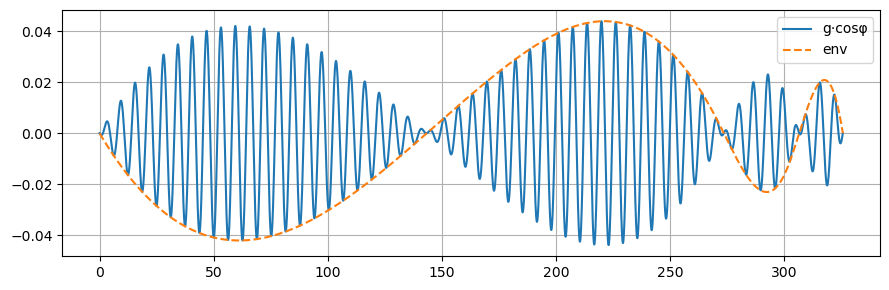

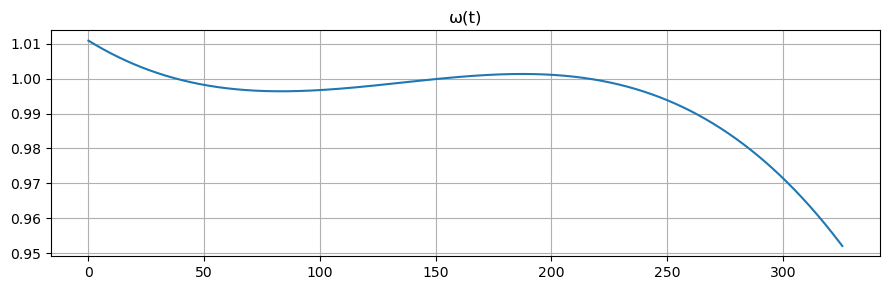

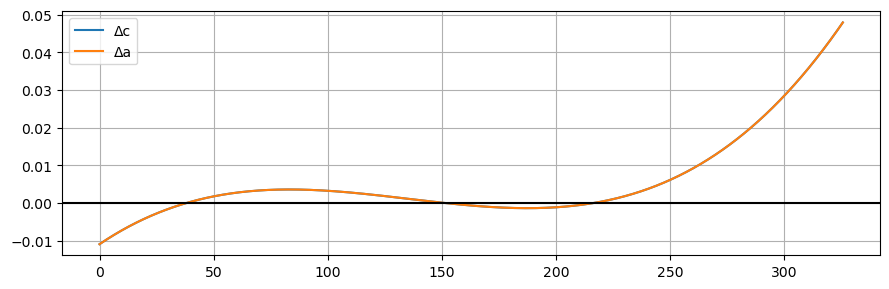

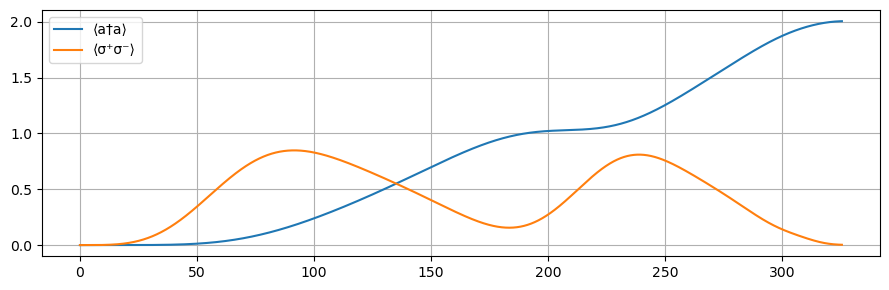

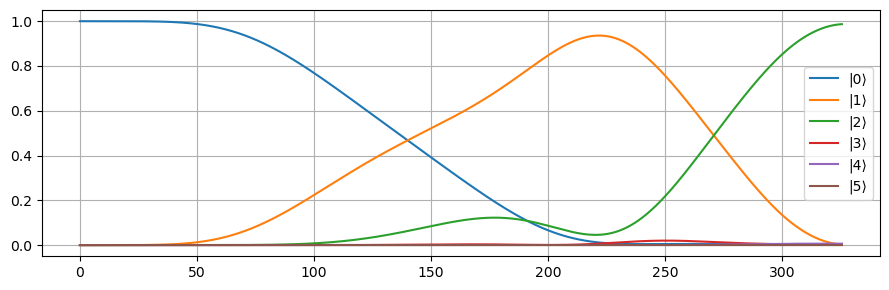

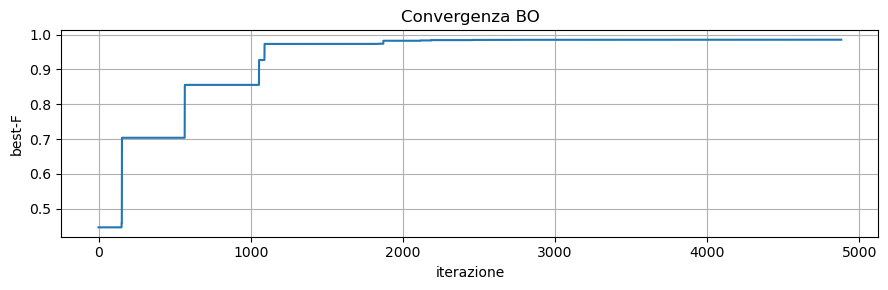

In [19]:
# =============================================================
#   Jaynes–Cummings  |  UCB-BayesOpt + Domain Reduction (n = 2)
#   target: F ≥ 0.99  |  3 plot rapidi  |  no RL
# =============================================================
# pip install -U qutip numpy matplotlib scipy bayesian-optimization
# =============================================================

import warnings, numpy as np, matplotlib.pyplot as plt, time
warnings.filterwarnings("ignore", category=FutureWarning)

from qutip import destroy, qeye, tensor, fock, basis, mesolve, Qobj, expect
from scipy.interpolate import CubicSpline
from bayes_opt import BayesianOptimization

# ---------- helper spline ---------------------------------------------------
def safe_cubic(xs, ys):
    cs = CubicSpline(xs, ys, extrapolate=True)
    return lambda t: float(cs(t)) if xs[0] <= t <= xs[-1] else 0.0


# ---------- UCB universale --------------------------------------------------
class _UCB:
    def __init__(self, kappa=2.5, n_candidates=25_000):
        self.kappa = kappa
        self.n_candidates = n_candidates

    def __call__(self, x, gp, y_max, xi):
        mu, sd = gp.predict(x, return_std=True)
        return mu.ravel() + self.kappa * sd

    def suggest(self, gp, target_space, fit_gp=True, random_state=None):
        rng = np.random.default_rng(
            None if random_state is None
            else getattr(random_state, "randint", lambda _: random_state)(2**32-1)
        )
        try:    X = target_space.random_points(self.n_candidates, random_state=rng)
        except AttributeError:
            try: X = target_space.random_sample(self.n_candidates)
            except AttributeError:
                b = np.asarray(target_space.bounds); lo, hi = b[:,0], b[:,1]
                X = rng.random((self.n_candidates, b.shape[0]))*(hi-lo)+lo
        mu, sd = gp.predict(X, return_std=True)
        return X[(mu + self.kappa*sd).argmax()]


# ---------- spazio parametri -----------------------------------------------
def build_space(n, g, wa):
    Nenv, amp = n + 3, 3.0 * g
    dims, pb = [], {}

    for i in range(Nenv):
        d = f"Y{i+1}"; dims.append(d); pb[d] = (-amp, amp)
    for i in range(Nenv):
        d = f"DX{i+1}"; dims.append(d); pb[d] = (0.05, 0.95)

    dims += ["SimTime", "F1", "F2", "FX1", "FX2"]
    pb["SimTime"] = (3.0/g, 10.0/g)
    pb["F1"] = (0.94*wa, 1.06*wa); pb["F2"] = pb["F1"]
    pb["FX1"] = (0.30, 0.50); pb["FX2"] = (0.55, 0.80)
    return dims, pb


# ---------- funzione costo (fidelità) ---------------------------------------
def make_cost(n, g, wc, wa, dims, psi0, proj):
    Nenv, n_cav = n + 3, n + 4
    a  = tensor(destroy(n_cav), qeye(2))
    σp = tensor(qeye(n_cav), Qobj([[0,1],[0,0]])); σm = σp.dag()
    σz = tensor(qeye(n_cav), Qobj([[1,0],[0,-1]]))

    def cost(**p):
        Y  = [p[f"Y{i+1}"] for i in range(Nenv)]
        DX = sorted(p[f"DX{i+1}"] for i in range(Nenv))
        if np.min(np.diff([0]+DX+[1])) <= 0: return 0.0
        τ   = p["SimTime"]
        env = safe_cubic([0]+(τ*np.array(DX)).tolist()+[τ], [0]+Y+[0])
        ω   = safe_cubic([0, τ*p["FX1"], τ*p["FX2"], τ], [p["F1"], wa, wa, p["F2"]])

        H = [g*(a.dag()*σm + a*σp),
             [a.dag()*a,   lambda t,*_: wc - ω(t)],
             [0.5*σz,      lambda t,*_: wa - ω(t)],
             [0.5*(σp+σm), lambda t,*_: env(t)]]

        try:
            ρf = mesolve(H, psi0, [0, τ], [], [],
                         options={'nsteps':4_00_000, 'atol':1e-7, 'rtol':1e-7}).states[-1]
            return float(expect(proj, ρf))
        except Exception:
            return 0.0
    return cost


# ---------- BO con domain-reduction ----------------------------------------
def ucb_bo(n=2, g=0.01, wc=1.0, wa=1.0,
           total_it=1200, seed=42,
           init_factor=5, dr_step=300, shrink=0.55,
           kappa0=2.8, kappa_min=1.0):

    dims, pb = build_space(n, g, wa)
    D = len(dims)
    init_pts = max(init_factor*D, 120)

    rng = np.random.default_rng(seed)
    psi0 = tensor(fock(n+4, 0), basis(2, 1))
    proj = tensor(fock(n+4, n).proj(), basis(2, 1).proj())
    cost = make_cost(n, g, wc, wa, dims, psi0, proj)

    ucb = _UCB(kappa=kappa0)
    try:
        opt = BayesianOptimization(f=None, pbounds=pb,
                                   acquisition_function=ucb,
                                   random_state=seed, verbose=0,
                                   allow_duplicate_points=True)
        new_api = True
    except TypeError:
        opt = BayesianOptimization(f=None, pbounds=pb,
                                   random_state=seed, verbose=0,
                                   allow_duplicate_points=True)
        new_api = False

    for _ in range(init_pts):
        x = {k: rng.uniform(*pb[k]) for k in pb}; opt.register(x, cost(**x))
    print(f"[Init] best F = {opt.max['target']:.4f}")

    t0 = time.time()
    history = [opt.max["target"]]
    for i in range(total_it - init_pts):
        frac = (i+1)/(total_it - init_pts)
        ucb.kappa = kappa0 - (kappa0 - kappa_min)*frac

        x = opt.suggest() if new_api else opt.suggest(ucb)
        y = cost(**x); opt.register(x, y)
        history.append(opt.max["target"])
        print(f"Iter {i+init_pts+1:04d}/{total_it}  "
              f"F:{y:6.4f} | Best:{opt.max['target']:6.4f}")

        if (i+1) % dr_step == 0:
            best = opt.max["params"]; new_pb = {}
            for d in dims:
                lo, hi = pb[d]; span = hi - lo; c = best[d]
                half = max(1e-6, span*shrink/2)
                new_pb[d] = (max(lo, c-half), min(hi, c+half))
            pb = new_pb; opt.set_bounds(new_pb)
            print(f" → domain shrunk (±{shrink*50:.0f}% )  "
                  f"| elapsed {time.time()-t0:.0f}s")

    best_p   = opt.max["params"]
    best_vec = np.array([best_p[d] for d in dims])
    return dims, best_vec, opt.max["target"], history


# ---------- plotting --------------------------------------------------------
def quick_plots(dims,x,n,hist,g=0.01,wc=1.0,wa=1.0):
    p=dict(zip(dims,x)); τ=p["SimTime"]; Nenv=n+3
    Y=[p[f"Y{i+1}"] for i in range(Nenv)]
    DX=sorted(p[f"DX{i+1}"] for i in range(Nenv))
    env=safe_cubic([0]+(τ*np.array(DX)).tolist()+[τ],[0]+Y+[0])
    ω=safe_cubic([0,τ*p["FX1"],τ*p["FX2"],τ],[p["F1"],wa,wa,p["F2"]])

    t=np.linspace(0,τ,6000)
    g_t=np.array([env(tt) for tt in t]); ω_t=np.array([ω(tt) for tt in t])
    φ=np.cumsum(ω_t)*np.diff(t,prepend=0)

    plt.figure(figsize=(9,3))
    plt.plot(t,g_t*np.cos(φ),label='g·cosφ'); plt.plot(t,g_t,'--',label='env')
    plt.legend(); plt.grid(); plt.tight_layout()

    plt.figure(figsize=(9,3)); plt.plot(t,ω_t)
    plt.title('ω(t)'); plt.grid(); plt.tight_layout()

    plt.figure(figsize=(9,3))
    plt.plot(t,wc-ω_t,label='Δc'); plt.plot(t,wa-ω_t,label='Δa')
    plt.axhline(0,c='k'); plt.legend(); plt.grid(); plt.tight_layout()

    n_cav=n+4
    a=tensor(destroy(n_cav),qeye(2))
    σp=tensor(qeye(n_cav),Qobj([[0,1],[0,0]])); σm=σp.dag(); σz=tensor(qeye(n_cav),Qobj([[1,0],[0,-1]]))
    H=[g*(a.dag()*σm+a*σp),
       [a.dag()*a,   lambda t,*args: wc-ω(t)],
       [0.5*σz,      lambda t,*args: wa-ω(t)],
       [0.5*(σp+σm), lambda t,*args: env(t)]]
    psi0=tensor(fock(n_cav,0),basis(2,1))
    from qutip.solver import Options
    opts = Options(nsteps=200_000, atol=1e-6, rtol=1e-6, store_states=True)
    out = mesolve(H, psi0, t, [], [a.dag()*a, σp*σm], options=opts)
    n_cav_mean, n_atom_mean = out.expect


    plt.figure(figsize=(9,3))
    plt.plot(t,n_cav_mean,label='⟨a†a⟩'); plt.plot(t,n_atom_mean,label='⟨σ⁺σ⁻⟩')
    plt.legend(); plt.grid(); plt.tight_layout()

    fock_pop={k:[] for k in range(min(6,n_cav))}
    for ρ in out.states:
        for k in fock_pop:
            proj=tensor(fock(n_cav,k).proj(),qeye(2))
            fock_pop[k].append(expect(proj,ρ))
    plt.figure(figsize=(9,3))
    for k,v in fock_pop.items():
        plt.plot(t,v,label=f'|{k}⟩')
    plt.legend(); plt.grid(); plt.tight_layout()

    plt.figure(figsize=(9,3))
    plt.plot(hist); plt.xlabel('iterazione'); plt.ylabel('best-F'); plt.title('Convergenza BO')
    plt.grid(); plt.tight_layout()
    plt.show()


# --------------------------- DEMO -------------------------------------------
if __name__=="__main__":
    dims,x_best,F,hist = ucb_bo(n=2,total_it=5000,seed=42)
    print(f"\nFinal best fidelity = {F:.4f}")
    quick_plots(dims,x_best,n=2,hist=hist)
